# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]

train_features = ["tau21j1"] # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 512 # Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00005
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")

# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Normalize all inputs between -1 and 1

scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

del df
gc.collect()

Dataset consists of 1464 batches of 512 samples each, total 749568 samples
Testset consists of 488 batches of 512 samples each, total 249856 samples


0

In [7]:
X_train

array([[-0.14896649],
       [ 0.32673728],
       [-0.22411472],
       ...,
       [-0.40730852],
       [-0.13658857],
       [-0.39947516]], dtype=float32)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [10]:
generator = make_generator_model()

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [12]:
discriminator = make_discriminator_model()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [14]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [15]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [16]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [17]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [18]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [19]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [20]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [21]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.normal([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [22]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [23]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.normal([BATCH_SIZE,len(train_features)])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [24]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.title("N-subjettiness ratio")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("$\\tau_{21J_2}$")
    plt.hist(scaler.inverse_transform(X_train), bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [25]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [26]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [27]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [28]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = False #((epoch + 1) % 20 == 0)
    draw_outputs = ((epoch + 1) % 10 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)
      graph_genloss()
      graph_discloss()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▋                                                                              | 9/1000 [02:42<4:49:53, 17.55s/it]


Epoch 10:


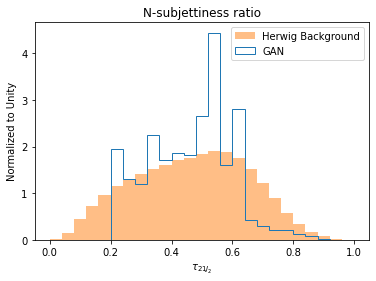

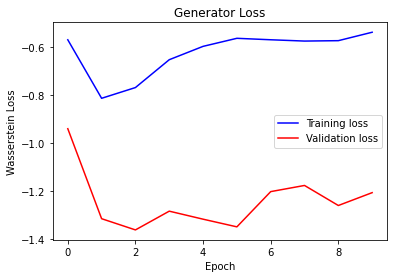

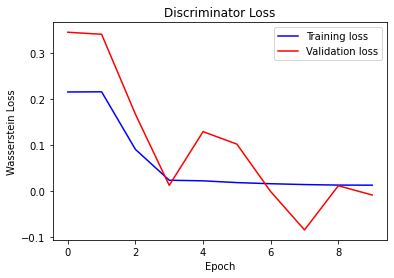

  2%|█▍                                                                            | 19/1000 [05:31<4:32:58, 16.70s/it]


Epoch 20:


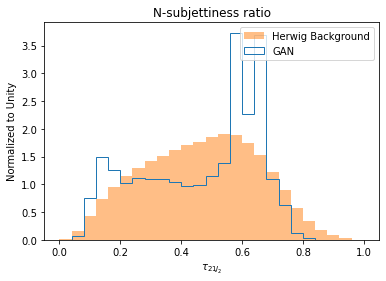

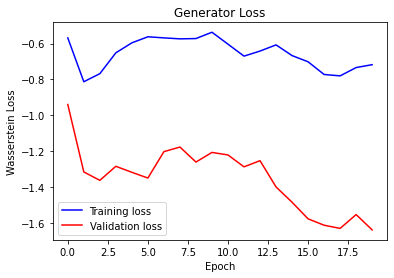

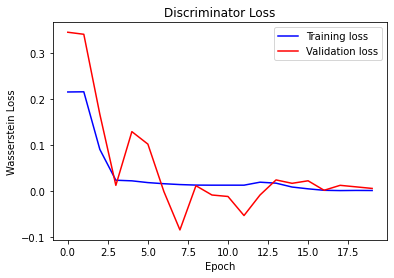

  3%|██▎                                                                           | 29/1000 [08:18<4:29:07, 16.63s/it]


Epoch 30:


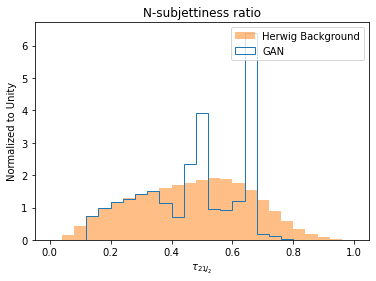

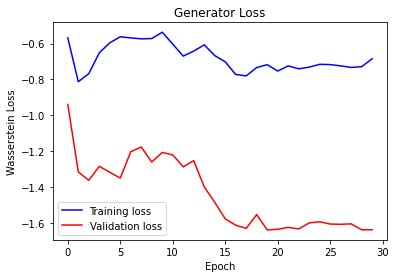

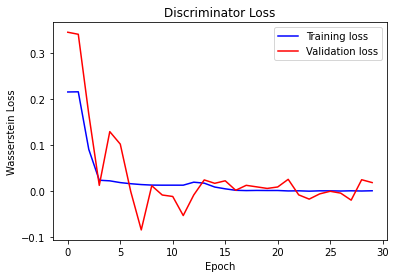

  4%|███                                                                           | 39/1000 [11:07<4:27:54, 16.73s/it]


Epoch 40:


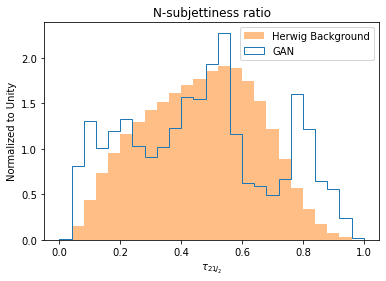

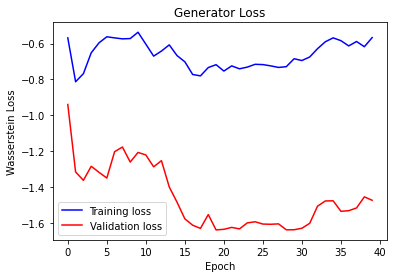

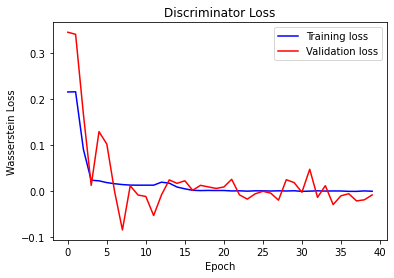

  5%|███▊                                                                          | 49/1000 [13:54<4:25:28, 16.75s/it]


Epoch 50:


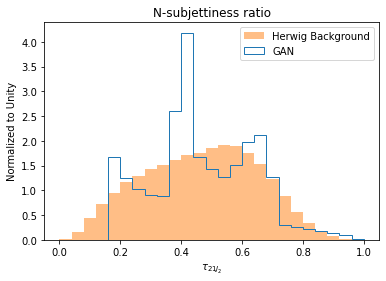

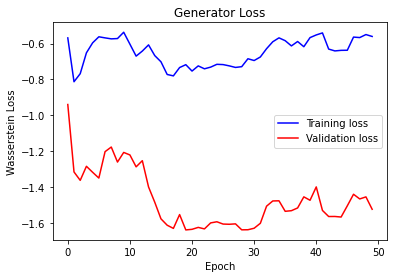

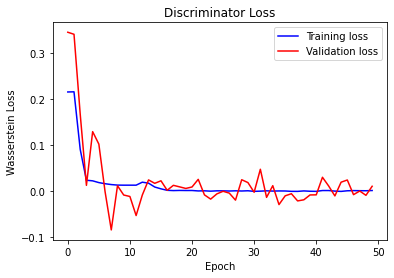

  6%|████▌                                                                         | 59/1000 [16:42<4:23:33, 16.80s/it]


Epoch 60:


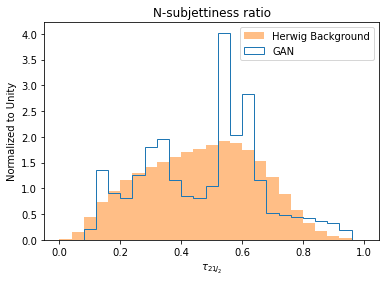

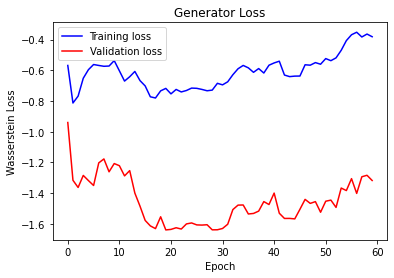

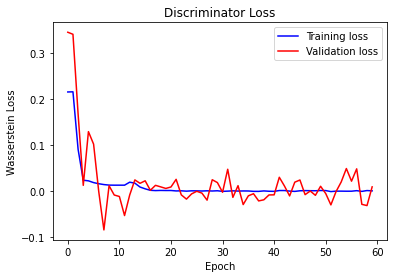

  7%|█████▍                                                                        | 69/1000 [19:25<4:13:59, 16.37s/it]


Epoch 70:


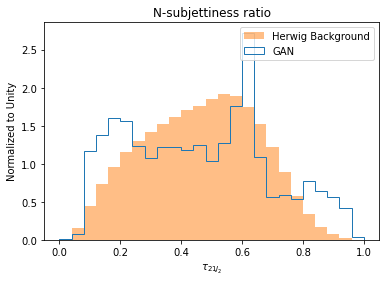

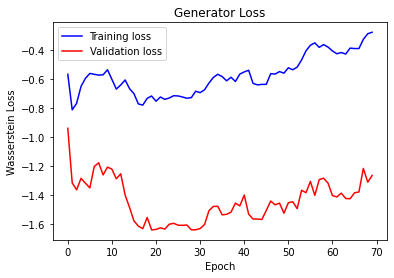

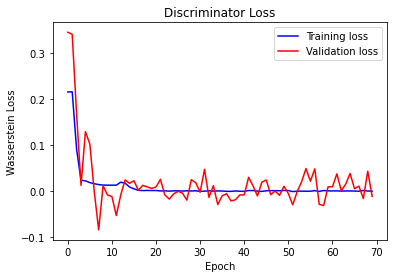

  8%|██████▏                                                                       | 79/1000 [22:13<4:24:16, 17.22s/it]


Epoch 80:


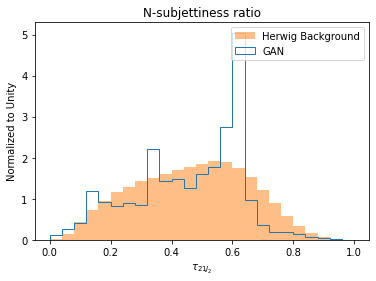

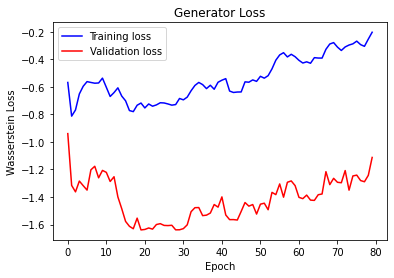

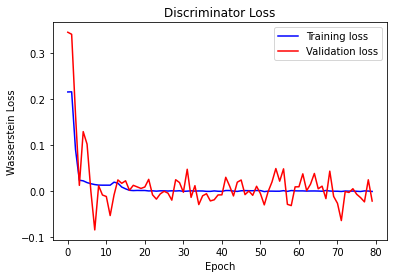

  9%|██████▉                                                                       | 89/1000 [25:13<4:33:49, 18.03s/it]


Epoch 90:


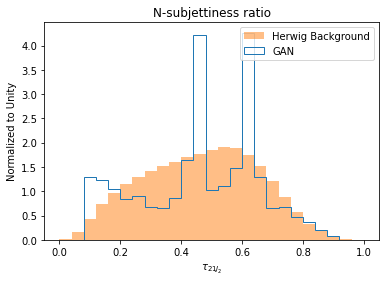

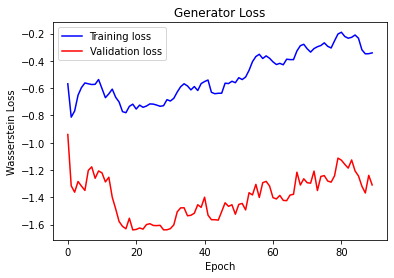

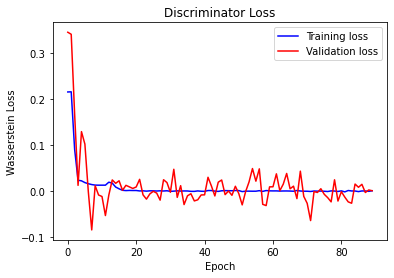

 10%|███████▋                                                                      | 99/1000 [28:07<4:22:11, 17.46s/it]


Epoch 100:


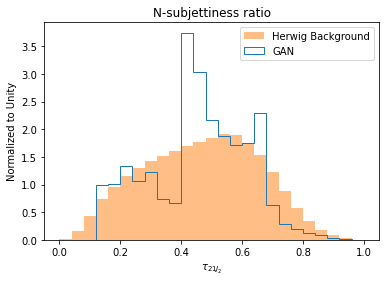

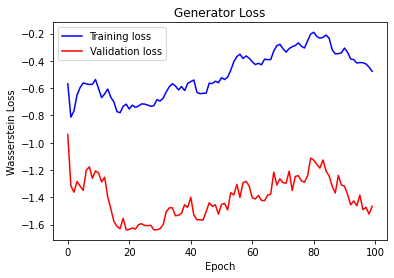

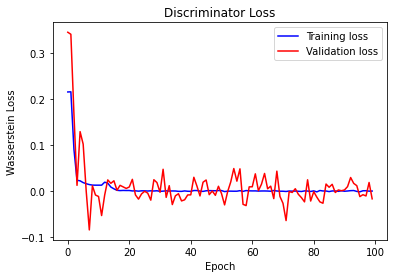

 11%|████████▍                                                                    | 109/1000 [31:09<4:30:06, 18.19s/it]


Epoch 110:


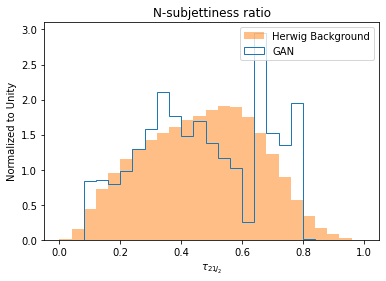

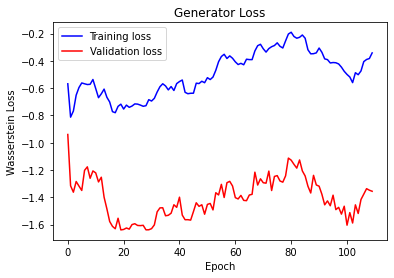

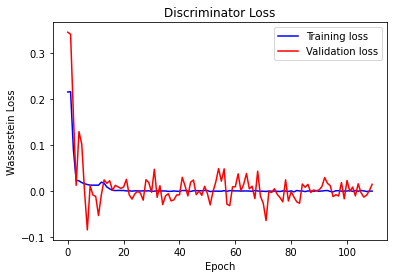

 12%|█████████▏                                                                   | 119/1000 [34:14<4:30:07, 18.40s/it]


Epoch 120:


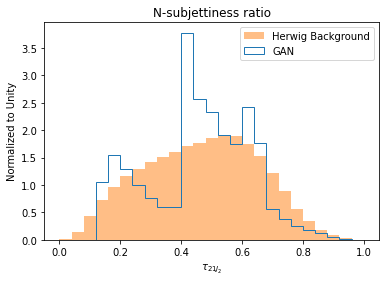

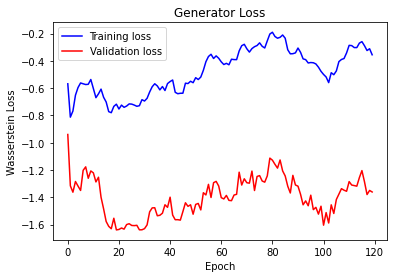

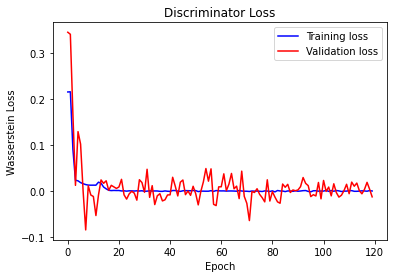

 13%|█████████▉                                                                   | 129/1000 [37:24<4:37:38, 19.13s/it]


Epoch 130:


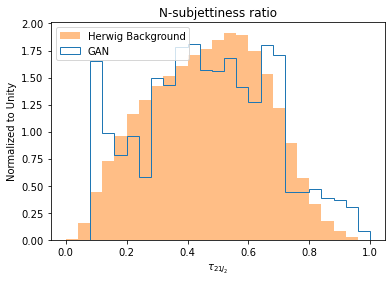

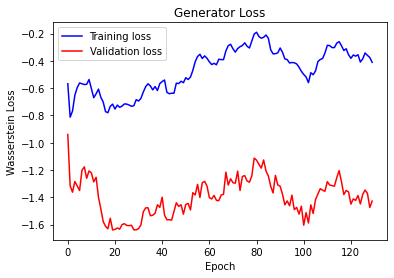

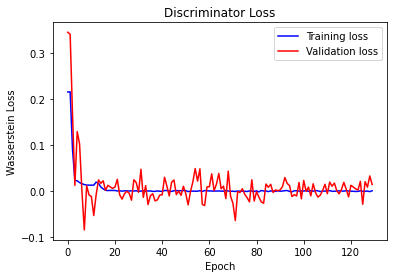

 14%|██████████▋                                                                  | 139/1000 [40:44<4:55:24, 20.59s/it]


Epoch 140:


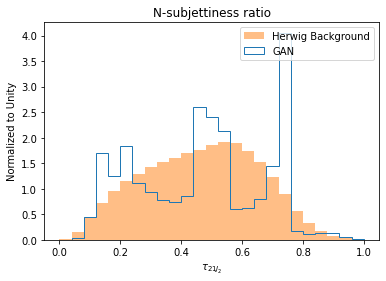

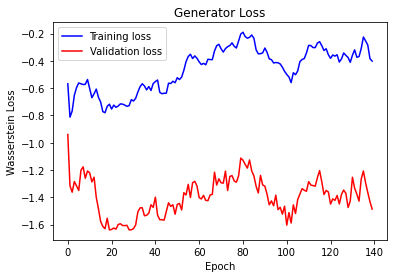

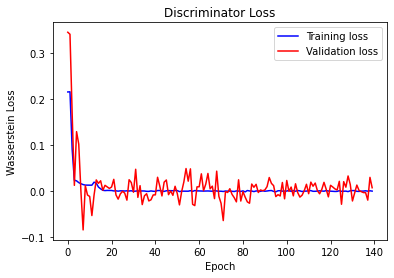

 15%|███████████▍                                                                 | 149/1000 [43:49<4:20:17, 18.35s/it]


Epoch 150:


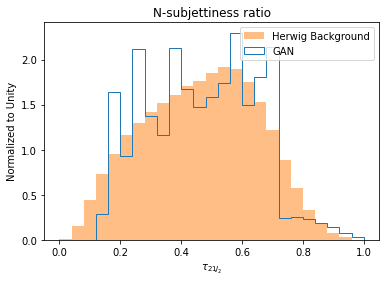

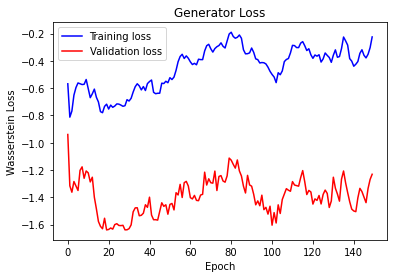

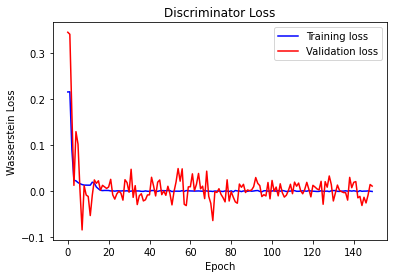

 16%|████████████▏                                                                | 159/1000 [46:50<4:18:39, 18.45s/it]


Epoch 160:


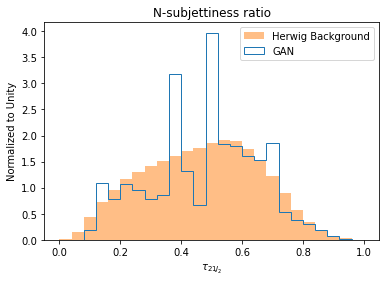

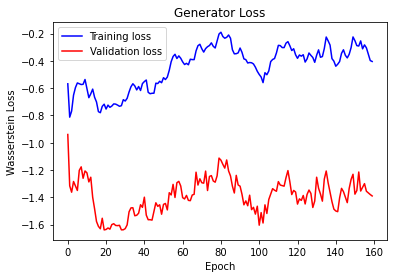

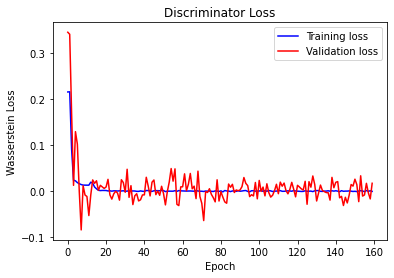

 17%|█████████████                                                                | 169/1000 [50:07<4:40:38, 20.26s/it]


Epoch 170:


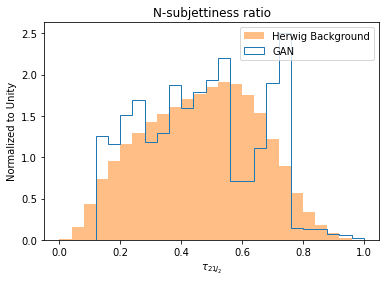

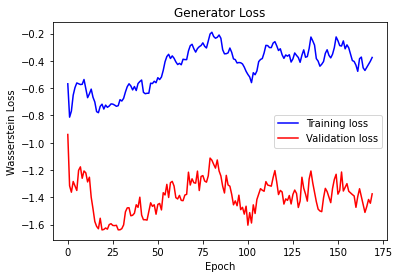

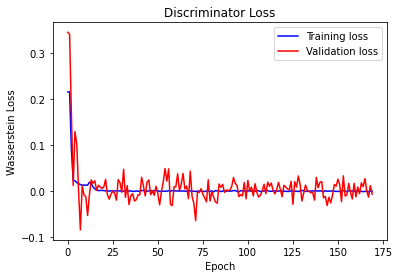

 18%|█████████████▊                                                               | 179/1000 [54:03<5:29:35, 24.09s/it]


Epoch 180:


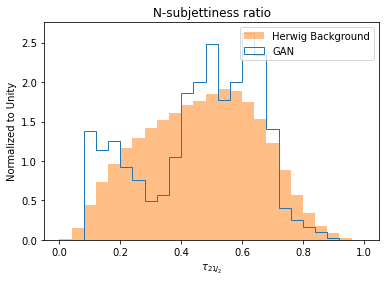

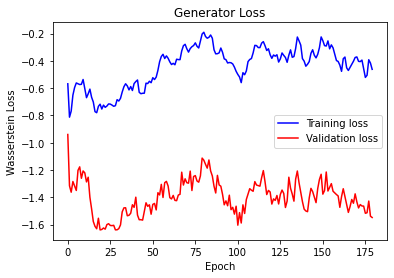

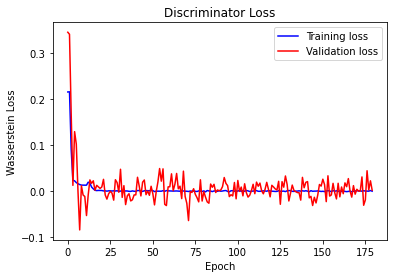

 19%|██████████████▌                                                              | 189/1000 [58:13<5:35:32, 24.82s/it]


Epoch 190:


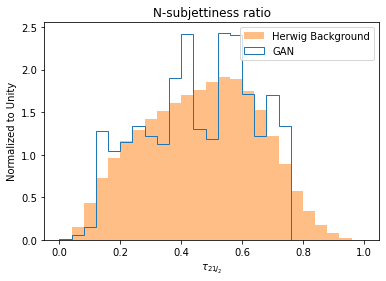

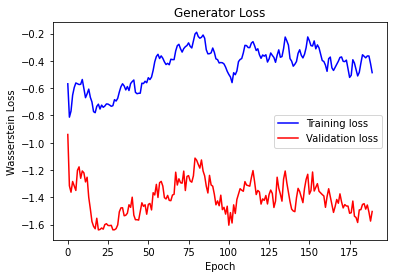

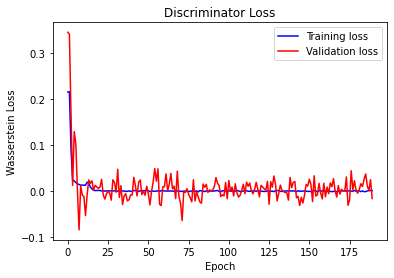

 20%|██████████████▉                                                            | 199/1000 [1:02:23<5:35:10, 25.11s/it]


Epoch 200:


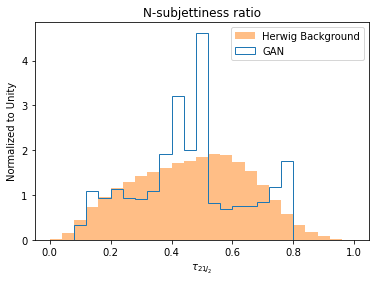

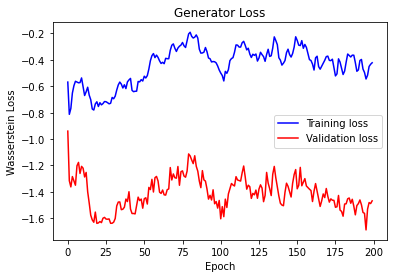

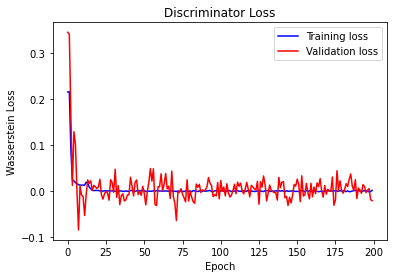

 21%|███████████████▋                                                           | 209/1000 [1:06:33<5:29:35, 25.00s/it]


Epoch 210:


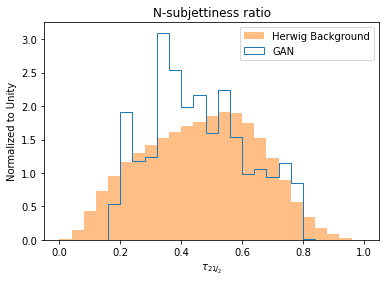

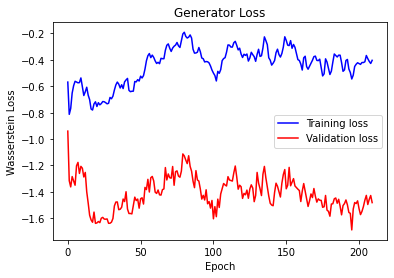

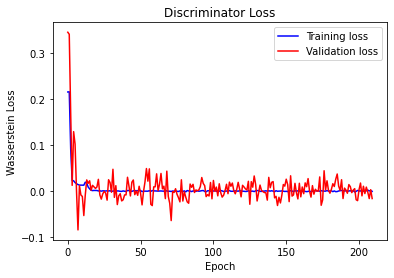

 22%|████████████████▍                                                          | 219/1000 [1:10:25<4:31:28, 20.86s/it]


Epoch 220:


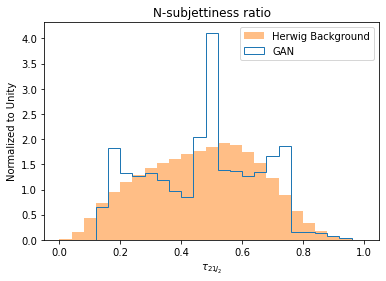

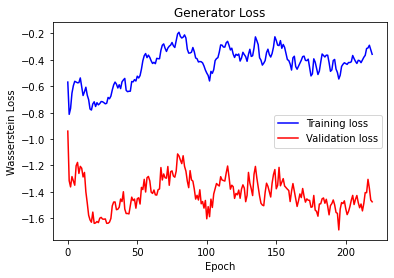

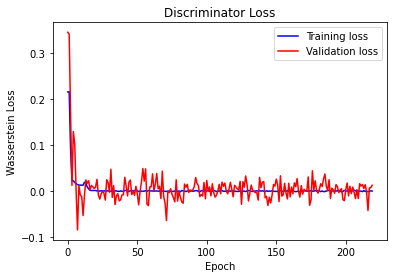

 23%|█████████████████▏                                                         | 229/1000 [1:13:23<3:48:51, 17.81s/it]


Epoch 230:


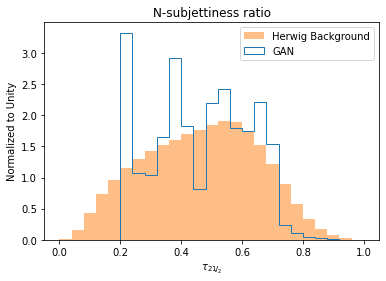

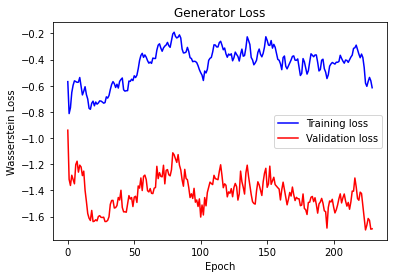

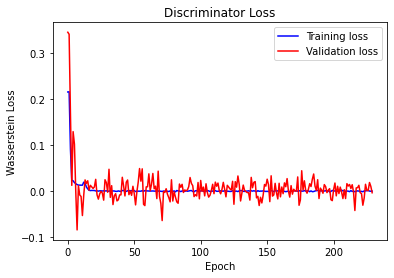

 24%|█████████████████▉                                                         | 239/1000 [1:16:32<4:00:57, 19.00s/it]


Epoch 240:


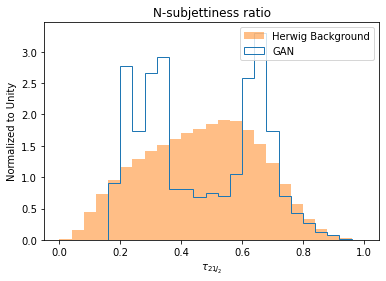

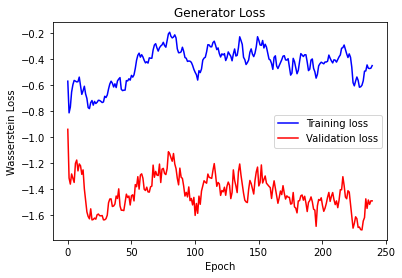

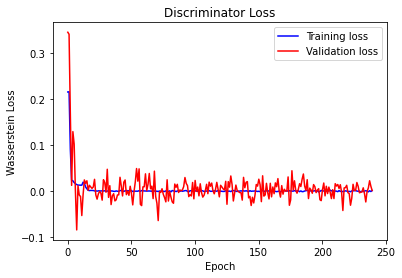

 25%|██████████████████▋                                                        | 249/1000 [1:19:44<4:05:51, 19.64s/it]


Epoch 250:


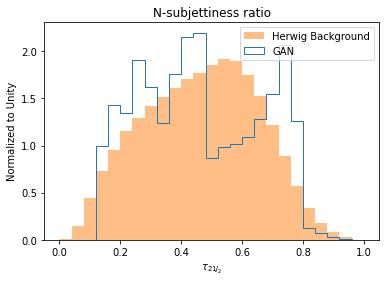

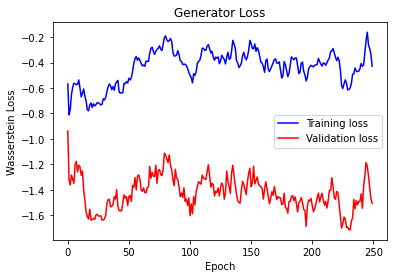

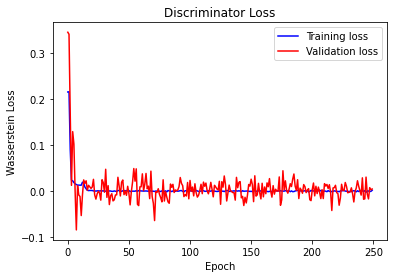

 26%|███████████████████▍                                                       | 259/1000 [1:22:52<3:51:32, 18.75s/it]


Epoch 260:


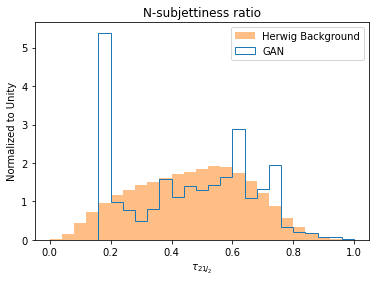

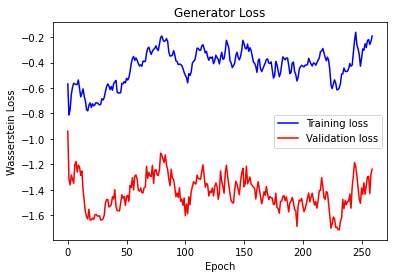

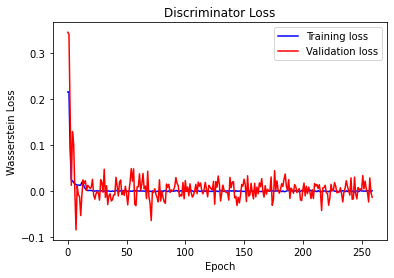

 27%|████████████████████▏                                                      | 269/1000 [1:25:57<3:46:58, 18.63s/it]


Epoch 270:


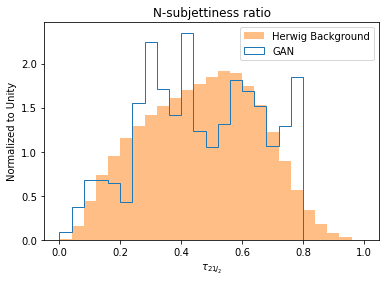

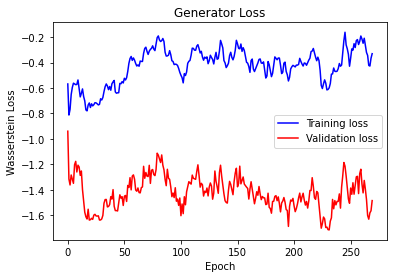

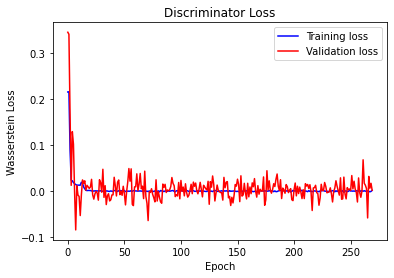

 28%|████████████████████▉                                                      | 279/1000 [1:29:04<3:50:49, 19.21s/it]


Epoch 280:


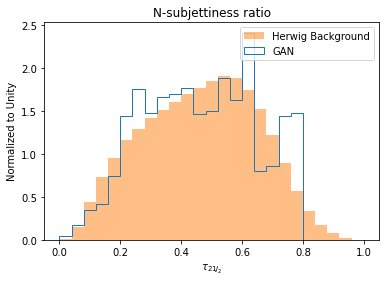

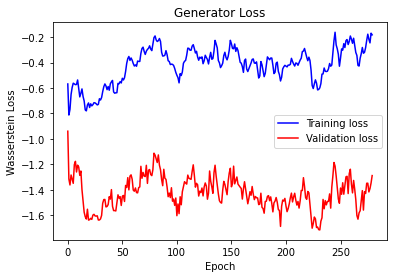

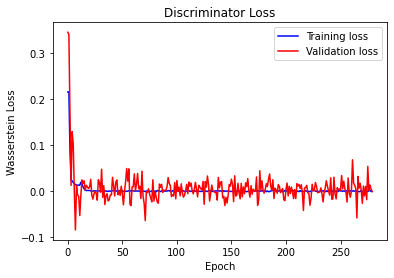

 29%|█████████████████████▋                                                     | 289/1000 [1:32:17<3:37:23, 18.35s/it]


Epoch 290:


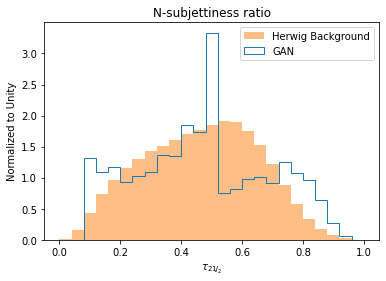

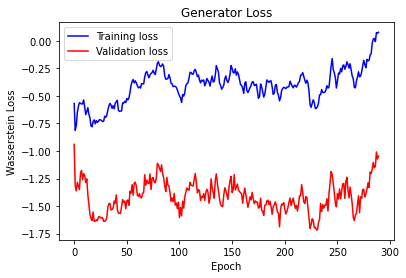

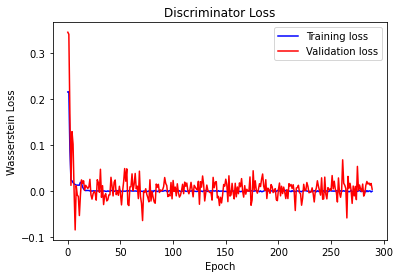

 30%|██████████████████████▍                                                    | 299/1000 [1:35:40<4:07:04, 21.15s/it]


Epoch 300:


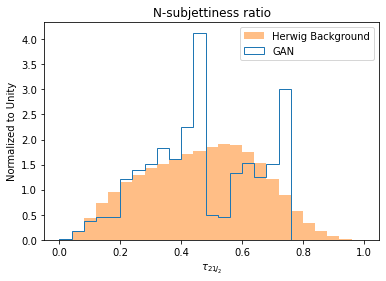

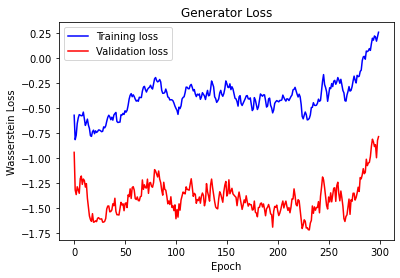

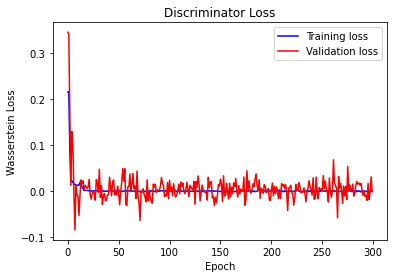

 31%|███████████████████████▏                                                   | 309/1000 [1:39:02<3:44:56, 19.53s/it]


Epoch 310:


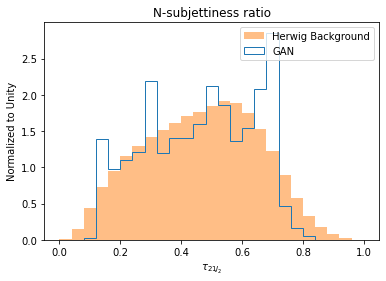

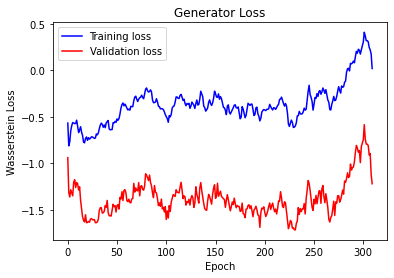

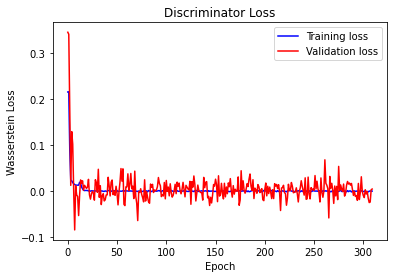

 32%|███████████████████████▉                                                   | 319/1000 [1:42:18<3:41:52, 19.55s/it]


Epoch 320:


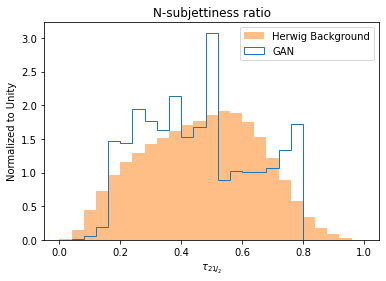

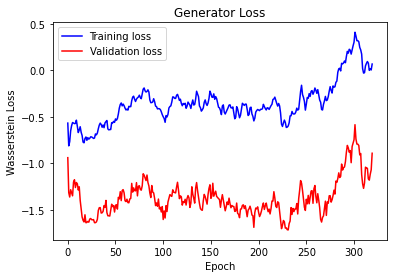

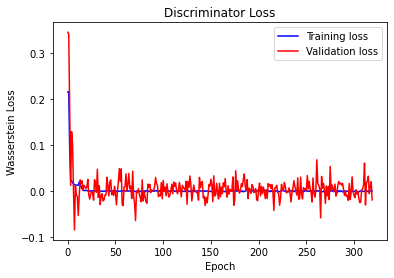

 33%|████████████████████████▋                                                  | 329/1000 [1:45:32<3:31:21, 18.90s/it]


Epoch 330:


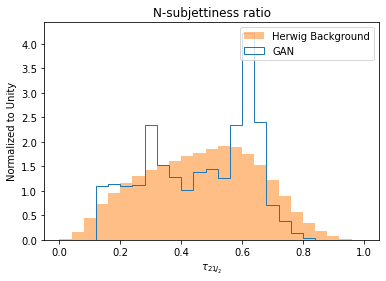

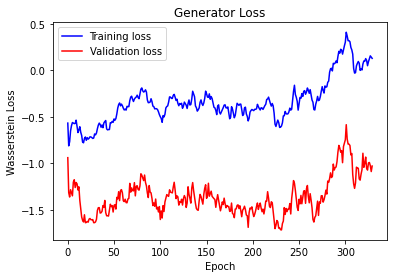

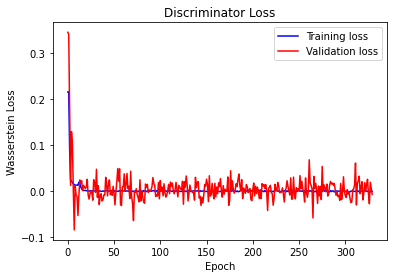

 34%|█████████████████████████▍                                                 | 339/1000 [1:48:31<3:18:16, 18.00s/it]


Epoch 340:


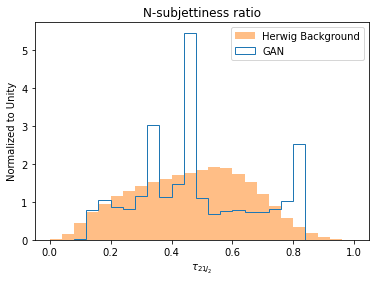

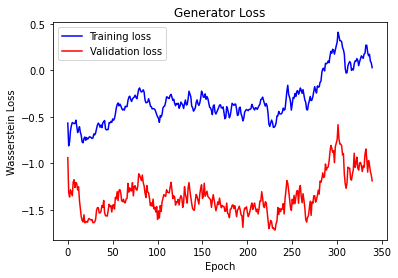

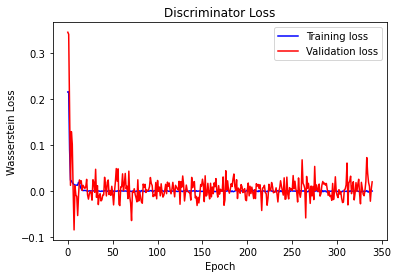

 35%|██████████████████████████▏                                                | 349/1000 [1:51:30<3:14:16, 17.91s/it]


Epoch 350:


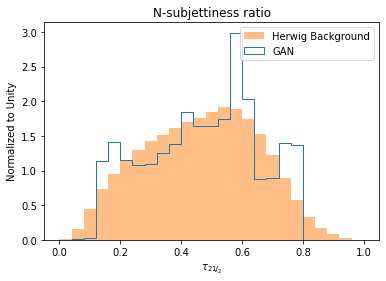

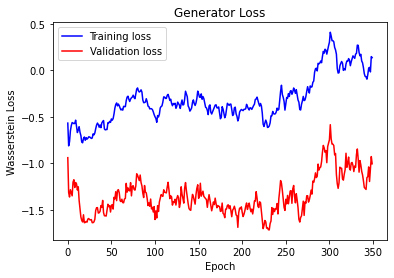

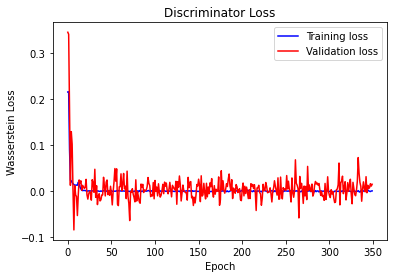

 36%|██████████████████████████▉                                                | 359/1000 [1:54:26<3:08:40, 17.66s/it]


Epoch 360:


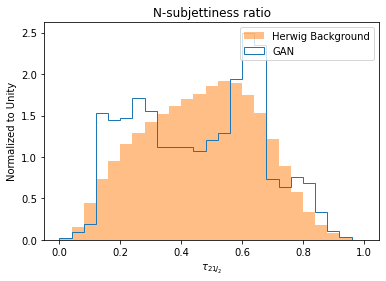

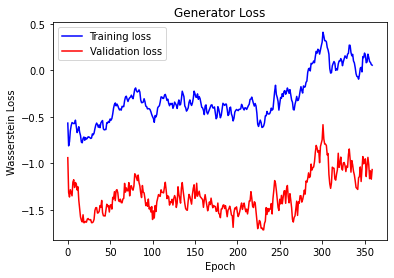

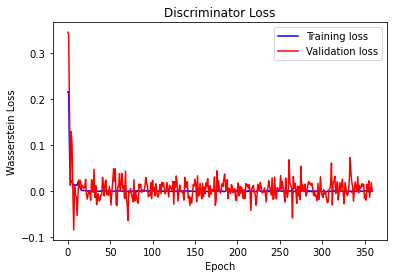

 37%|███████████████████████████▋                                               | 369/1000 [1:57:29<3:11:47, 18.24s/it]


Epoch 370:


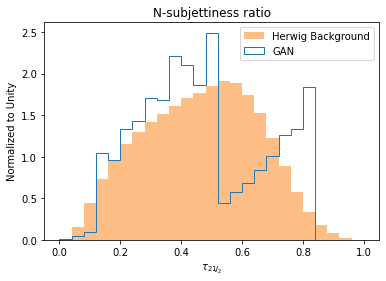

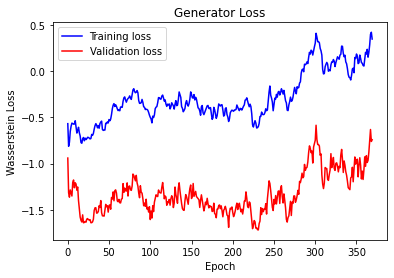

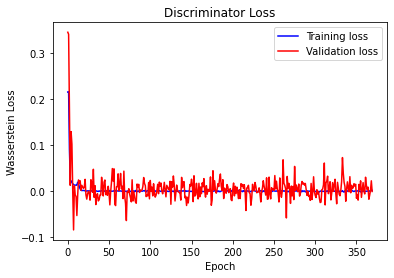

 38%|████████████████████████████▍                                              | 379/1000 [2:00:33<3:08:30, 18.21s/it]


Epoch 380:


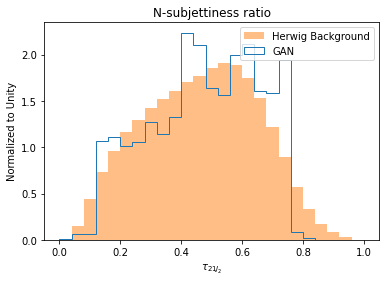

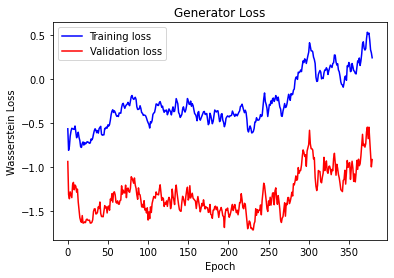

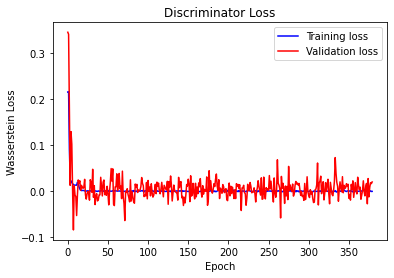

 39%|█████████████████████████████▏                                             | 389/1000 [2:03:33<3:03:19, 18.00s/it]


Epoch 390:


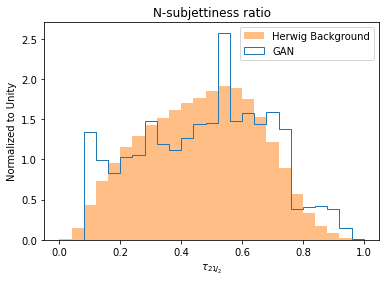

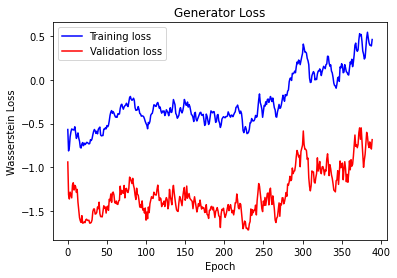

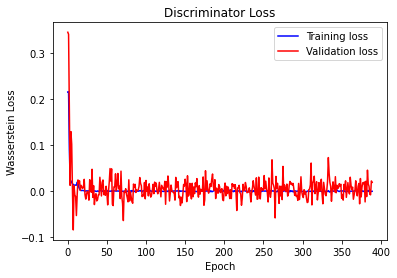

 40%|█████████████████████████████▉                                             | 399/1000 [2:06:36<3:04:09, 18.39s/it]


Epoch 400:


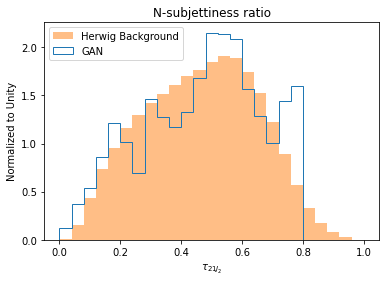

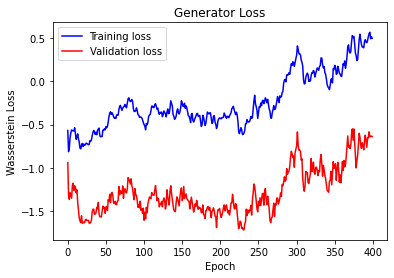

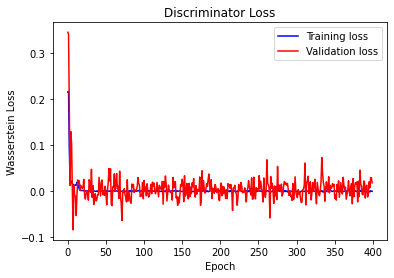

 41%|██████████████████████████████▋                                            | 409/1000 [2:09:38<2:58:54, 18.16s/it]


Epoch 410:


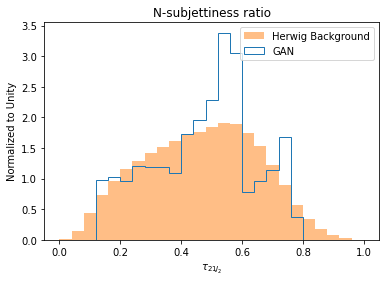

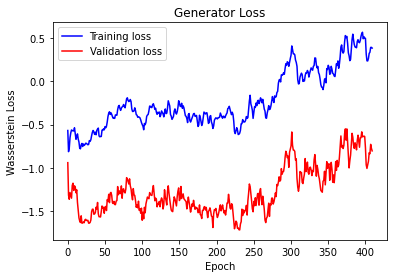

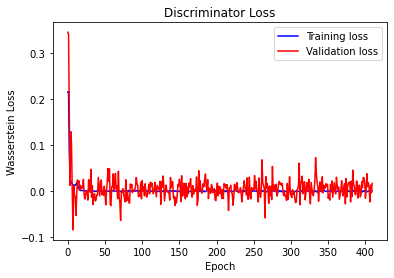

 42%|███████████████████████████████▍                                           | 419/1000 [2:12:39<2:55:44, 18.15s/it]


Epoch 420:


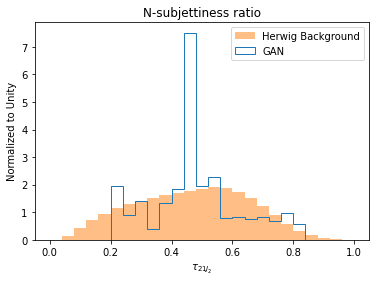

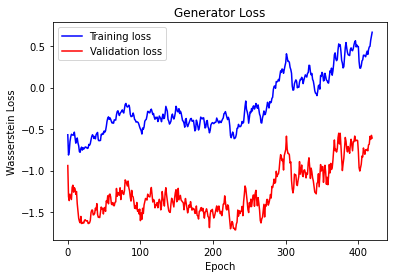

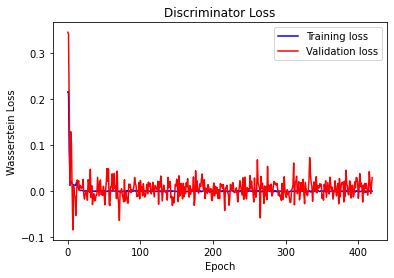

 43%|████████████████████████████████▏                                          | 429/1000 [2:15:43<2:51:48, 18.05s/it]


Epoch 430:


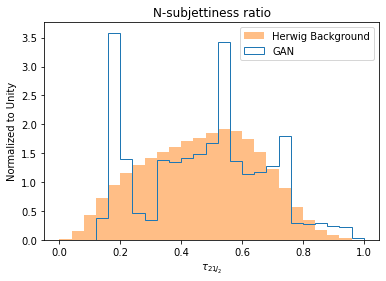

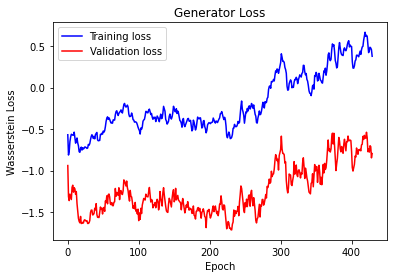

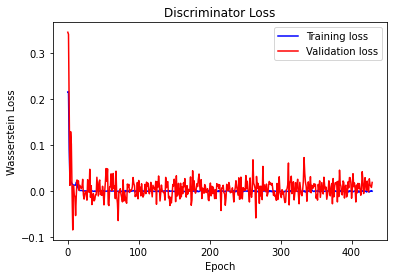

 44%|████████████████████████████████▉                                          | 439/1000 [2:18:42<2:52:16, 18.42s/it]


Epoch 440:


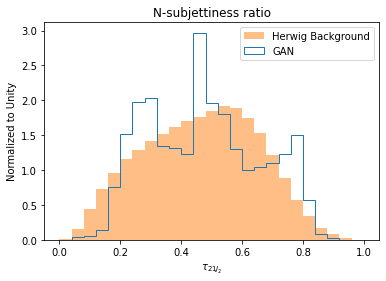

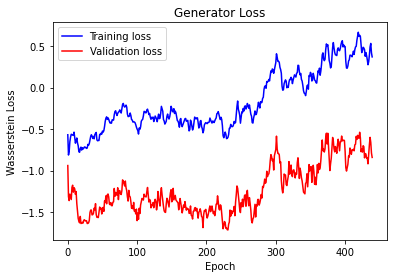

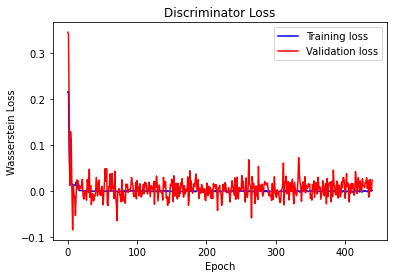

 45%|█████████████████████████████████▋                                         | 449/1000 [2:21:48<2:50:32, 18.57s/it]


Epoch 450:


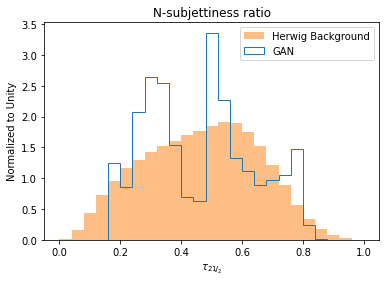

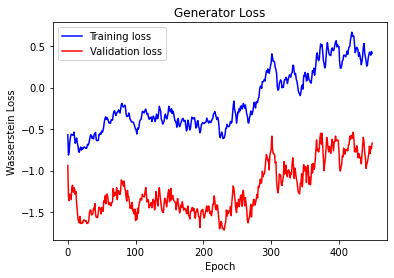

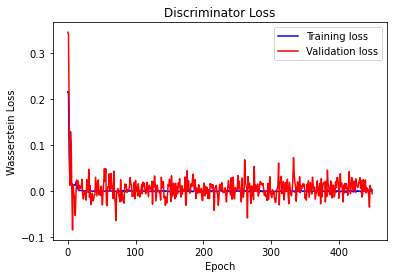

 46%|██████████████████████████████████▍                                        | 459/1000 [2:24:55<2:47:33, 18.58s/it]


Epoch 460:


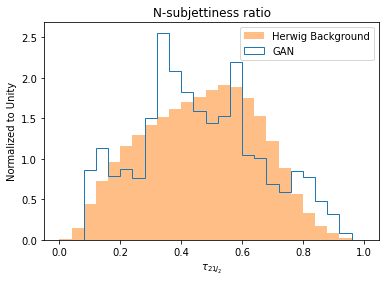

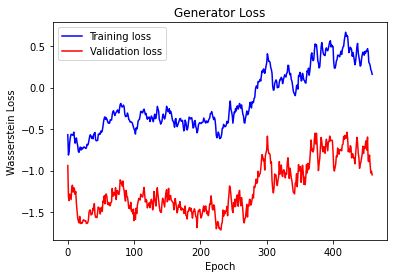

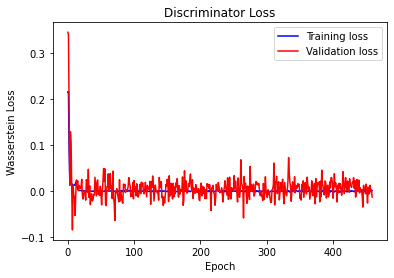

 47%|███████████████████████████████████▏                                       | 469/1000 [2:28:06<2:46:56, 18.86s/it]


Epoch 470:


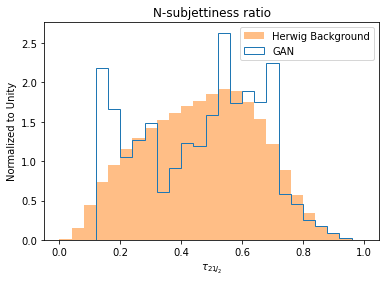

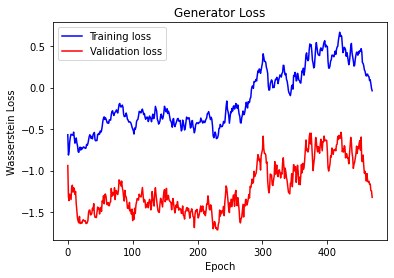

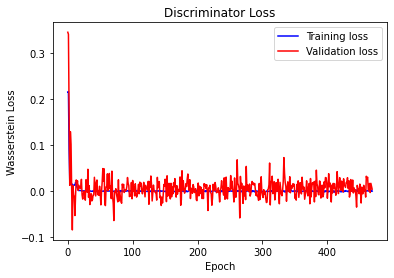

 48%|███████████████████████████████████▉                                       | 479/1000 [2:31:15<2:41:44, 18.63s/it]


Epoch 480:


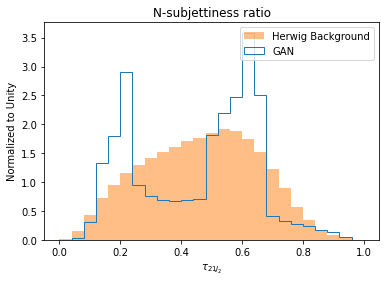

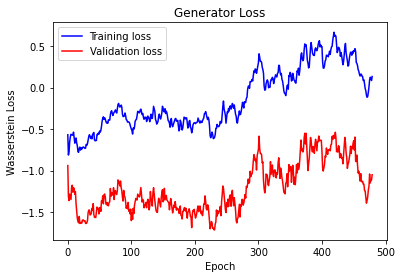

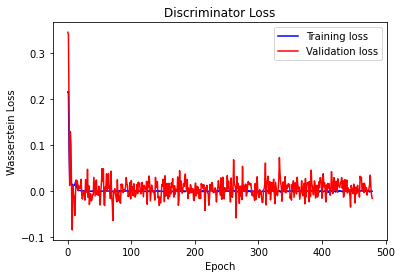

 49%|████████████████████████████████████▋                                      | 489/1000 [2:34:13<2:33:51, 18.07s/it]


Epoch 490:


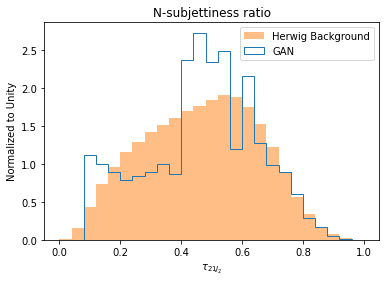

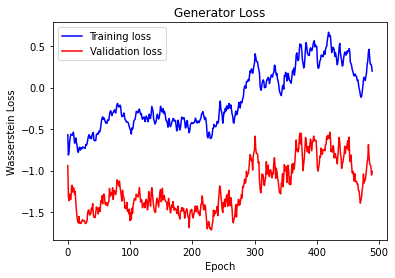

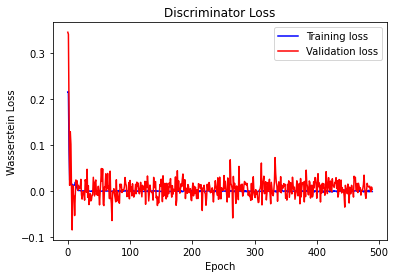

 50%|█████████████████████████████████████▍                                     | 499/1000 [2:37:13<2:28:58, 17.84s/it]


Epoch 500:


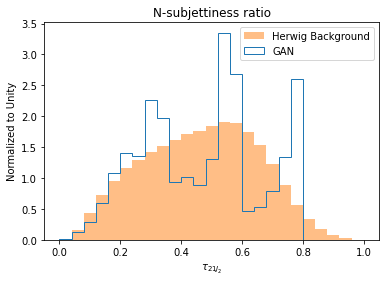

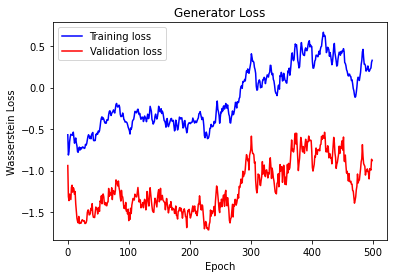

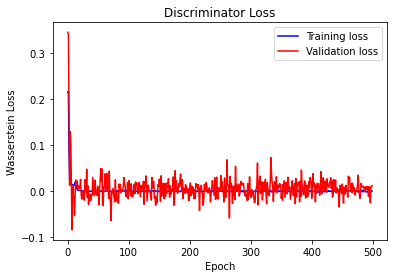

 51%|██████████████████████████████████████▏                                    | 509/1000 [2:40:16<2:30:02, 18.33s/it]


Epoch 510:


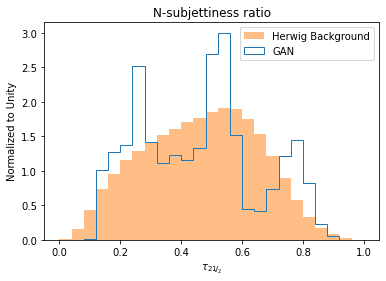

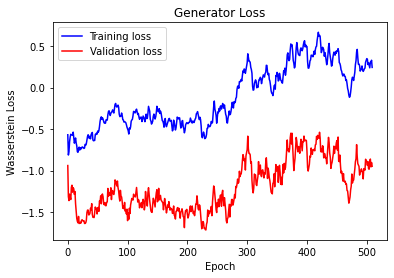

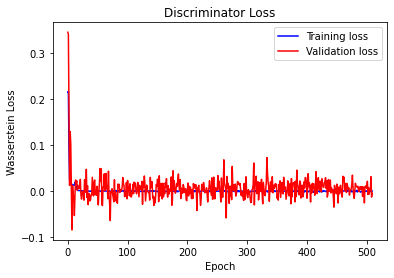

 52%|██████████████████████████████████████▉                                    | 519/1000 [2:43:12<2:18:03, 17.22s/it]


Epoch 520:


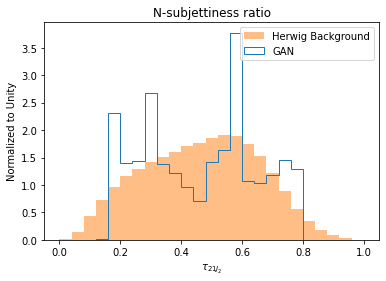

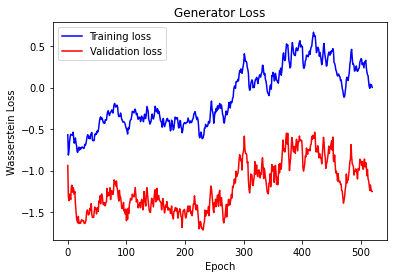

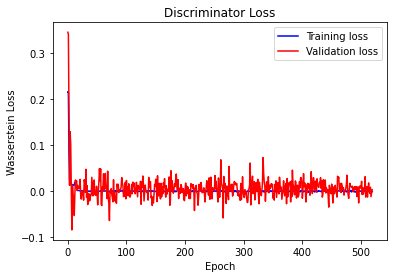

 53%|███████████████████████████████████████▋                                   | 529/1000 [2:45:56<2:08:16, 16.34s/it]


Epoch 530:


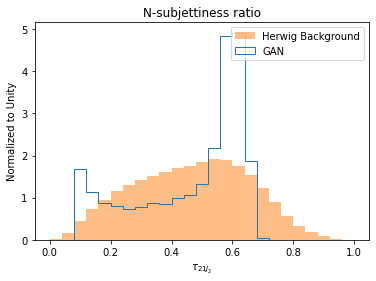

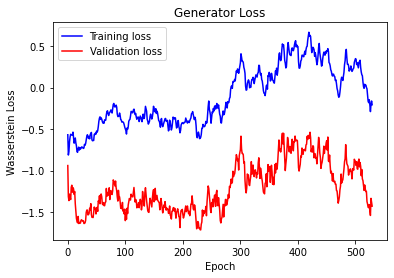

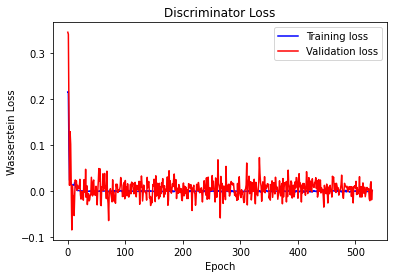

 54%|████████████████████████████████████████▍                                  | 539/1000 [2:48:40<2:06:02, 16.41s/it]


Epoch 540:


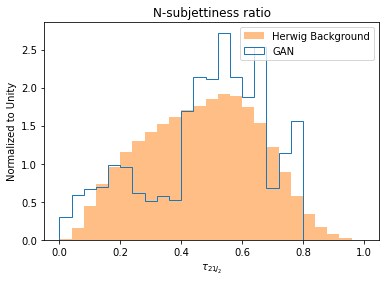

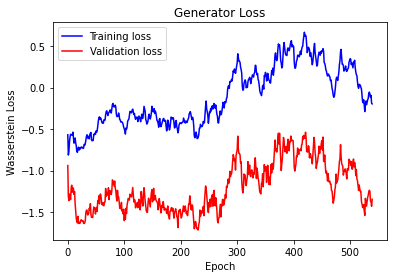

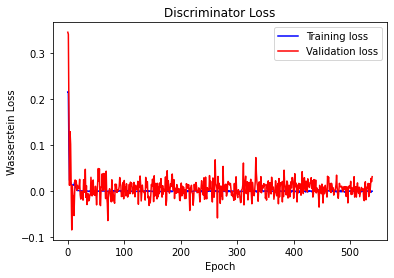

 55%|█████████████████████████████████████████▏                                 | 549/1000 [2:51:25<2:02:54, 16.35s/it]


Epoch 550:


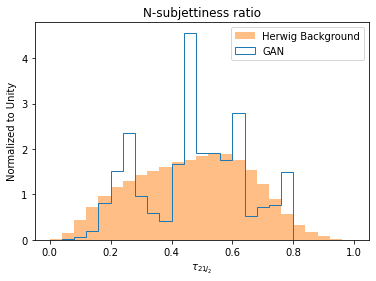

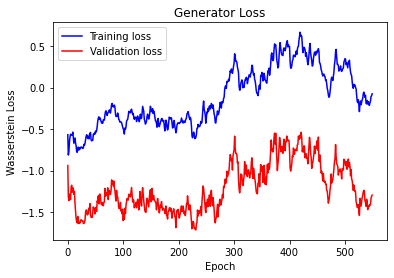

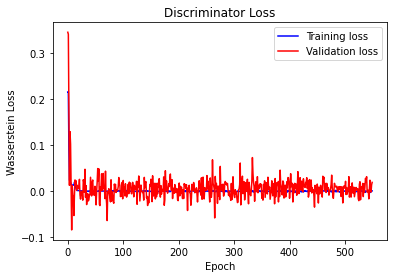

 56%|█████████████████████████████████████████▉                                 | 559/1000 [2:54:15<2:05:37, 17.09s/it]


Epoch 560:


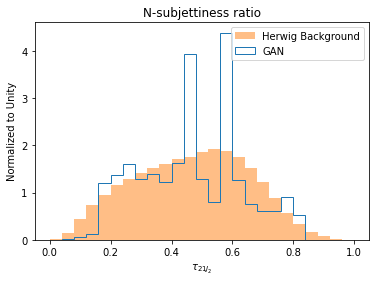

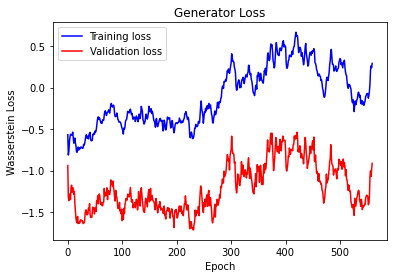

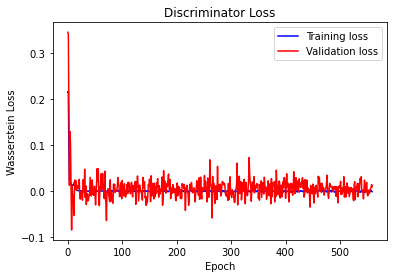

 57%|██████████████████████████████████████████▋                                | 569/1000 [2:57:15<2:10:55, 18.23s/it]


Epoch 570:


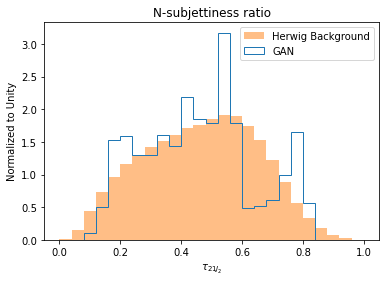

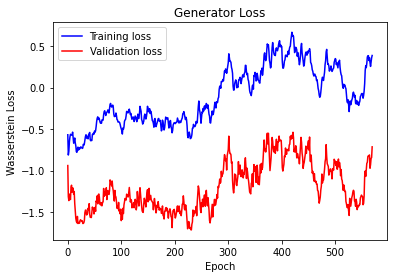

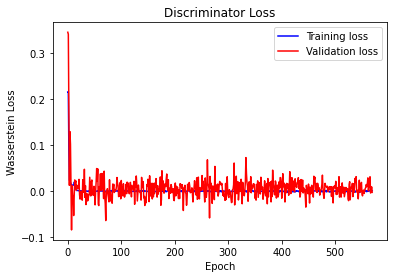

 58%|███████████████████████████████████████████▍                               | 579/1000 [3:00:16<2:07:10, 18.13s/it]


Epoch 580:


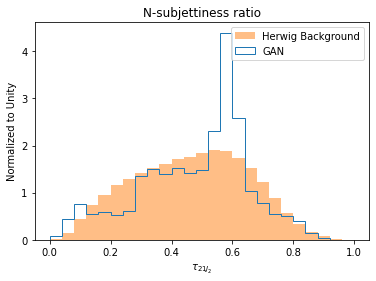

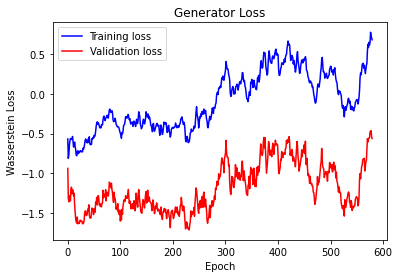

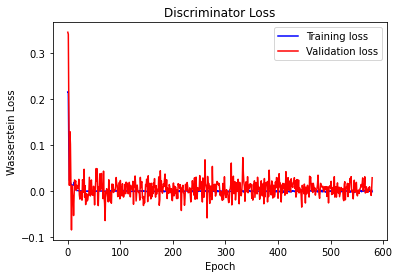

 59%|████████████████████████████████████████████▏                              | 589/1000 [3:03:21<2:02:52, 17.94s/it]


Epoch 590:


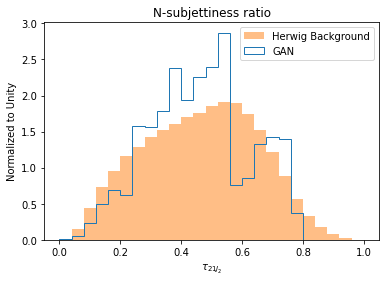

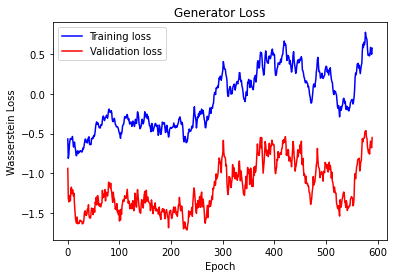

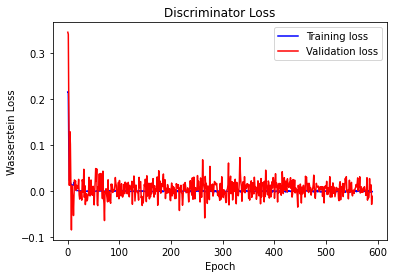

 60%|████████████████████████████████████████████▉                              | 599/1000 [3:06:26<2:04:00, 18.56s/it]


Epoch 600:


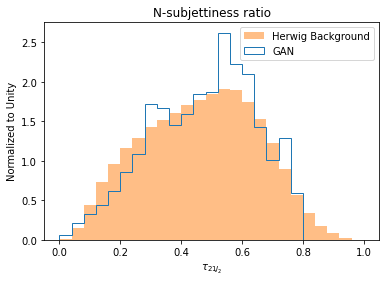

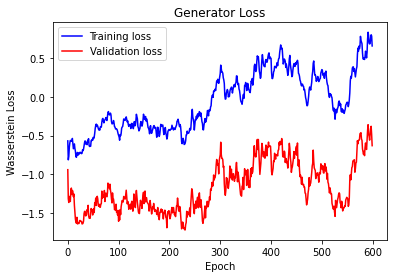

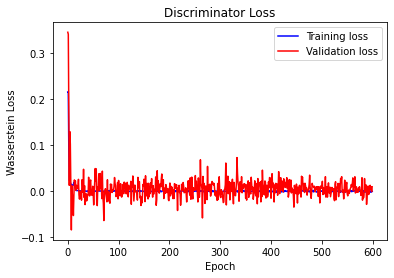

 61%|█████████████████████████████████████████████▋                             | 609/1000 [3:09:32<2:01:33, 18.65s/it]


Epoch 610:


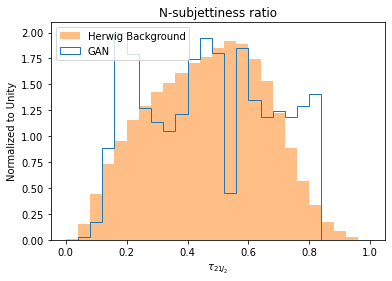

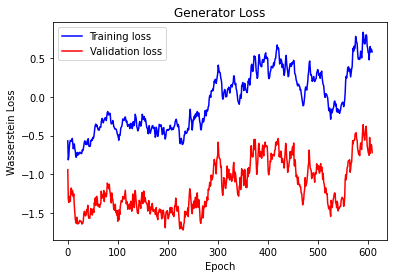

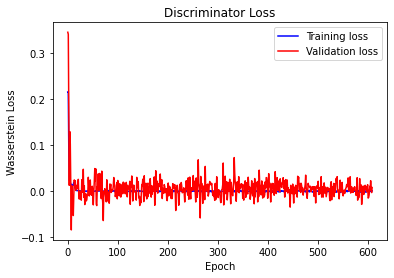

 62%|██████████████████████████████████████████████▍                            | 619/1000 [3:12:40<1:57:09, 18.45s/it]


Epoch 620:


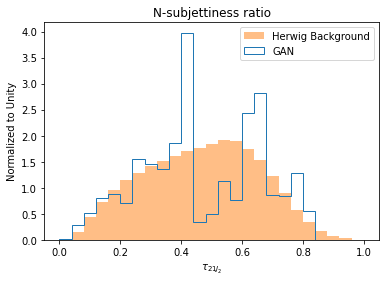

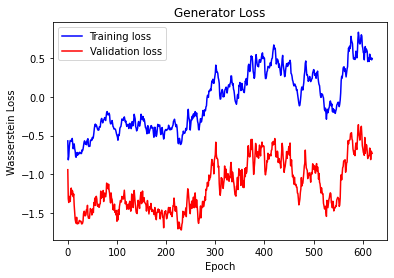

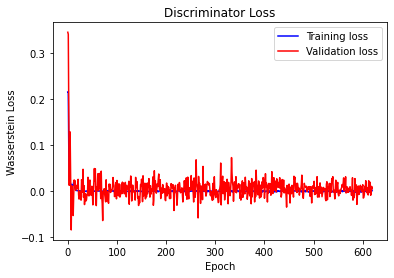

 63%|███████████████████████████████████████████████▏                           | 629/1000 [3:15:47<1:56:31, 18.85s/it]


Epoch 630:


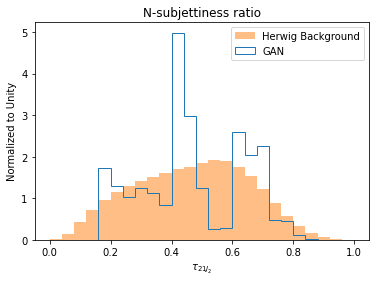

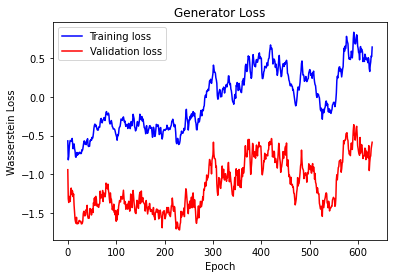

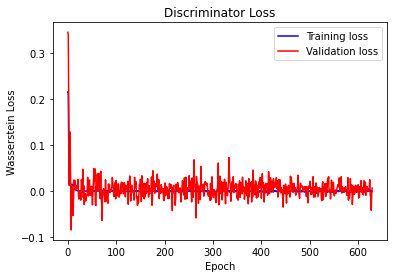

 64%|███████████████████████████████████████████████▉                           | 639/1000 [3:18:49<1:50:59, 18.45s/it]


Epoch 640:


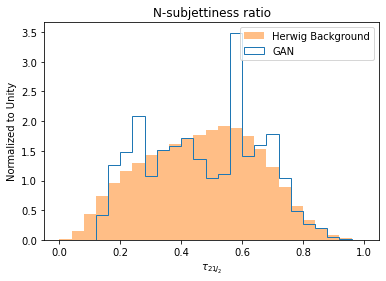

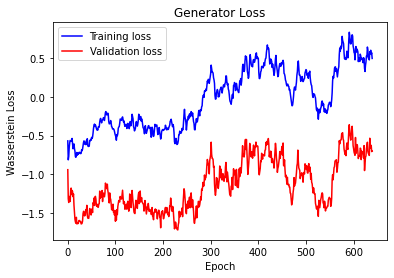

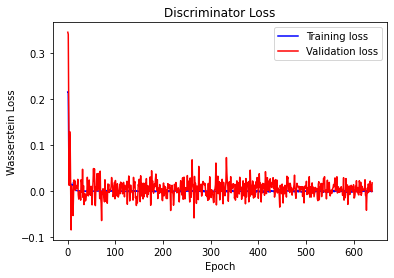

 65%|████████████████████████████████████████████████▋                          | 649/1000 [3:22:08<1:52:47, 19.28s/it]


Epoch 650:


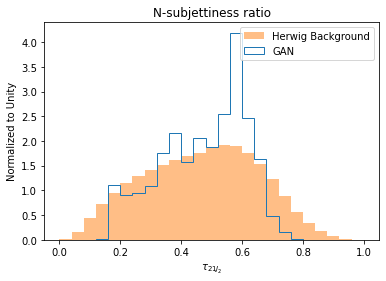

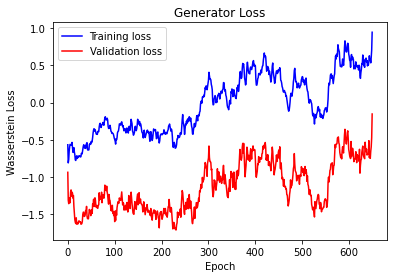

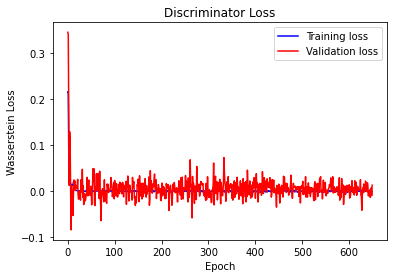

 66%|█████████████████████████████████████████████████▍                         | 659/1000 [3:25:09<1:43:03, 18.13s/it]


Epoch 660:


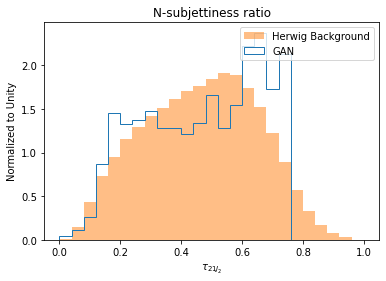

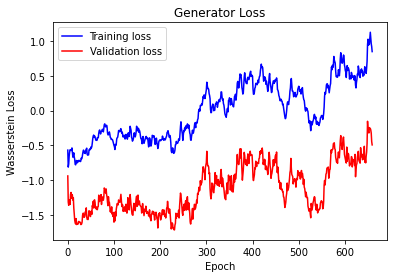

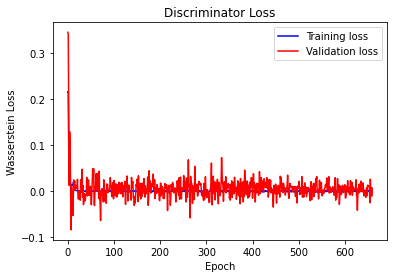

 67%|██████████████████████████████████████████████████▏                        | 669/1000 [3:28:10<1:38:03, 17.78s/it]


Epoch 670:


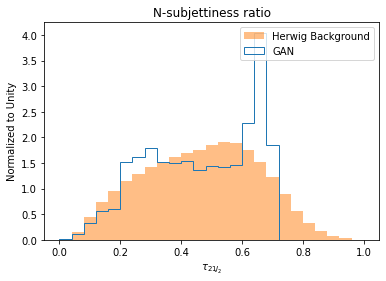

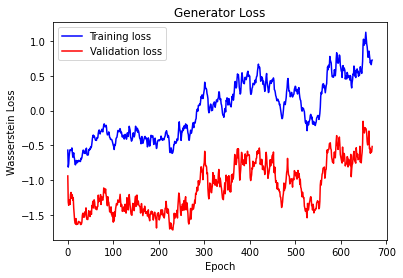

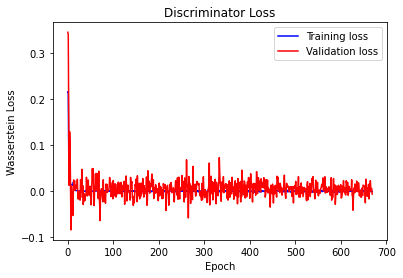

 68%|██████████████████████████████████████████████████▉                        | 679/1000 [3:31:16<1:40:03, 18.70s/it]


Epoch 680:


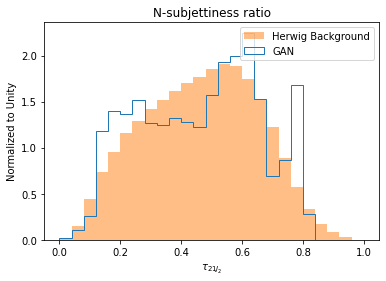

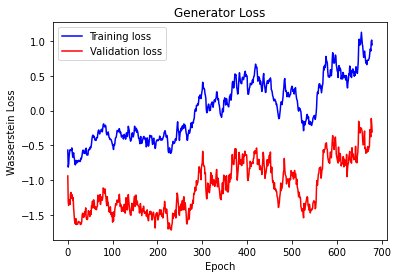

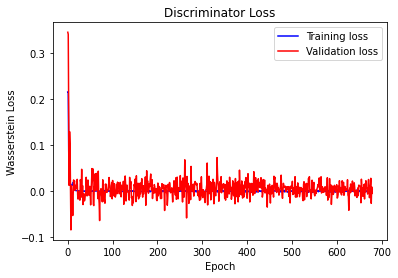

 69%|███████████████████████████████████████████████████▋                       | 689/1000 [3:34:19<1:33:58, 18.13s/it]


Epoch 690:


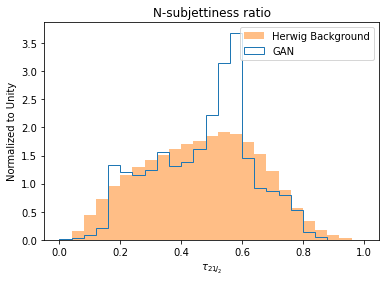

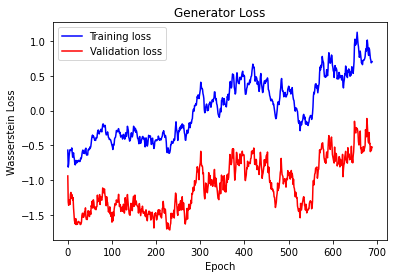

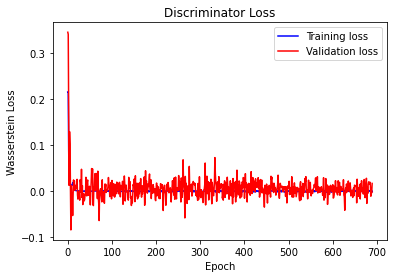

 70%|████████████████████████████████████████████████████▍                      | 699/1000 [3:37:27<1:34:10, 18.77s/it]


Epoch 700:


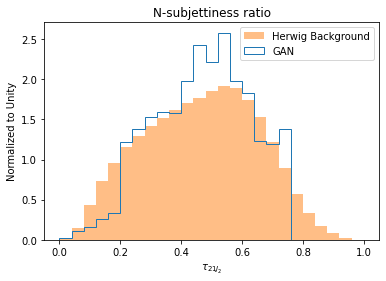

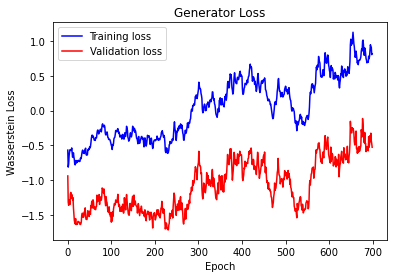

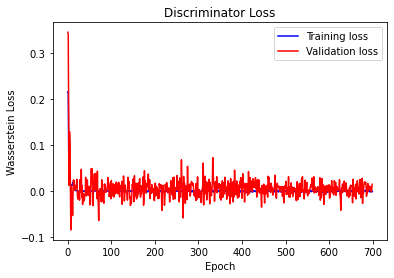

 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [3:40:53<1:38:24, 20.29s/it]


Epoch 710:


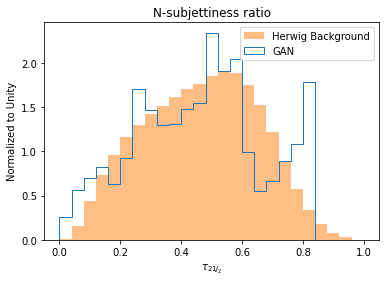

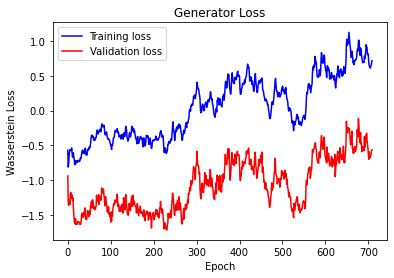

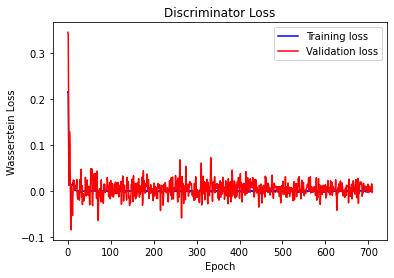

 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [3:44:47<1:54:43, 24.50s/it]


Epoch 720:


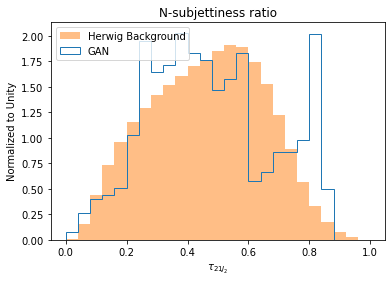

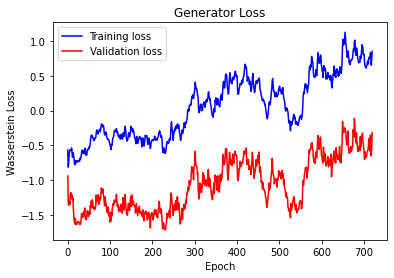

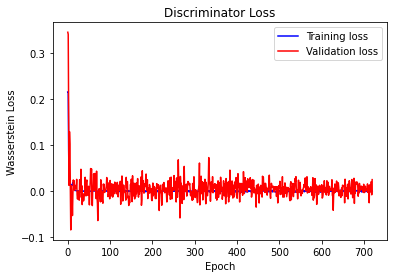

 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [3:48:56<1:53:11, 25.06s/it]


Epoch 730:


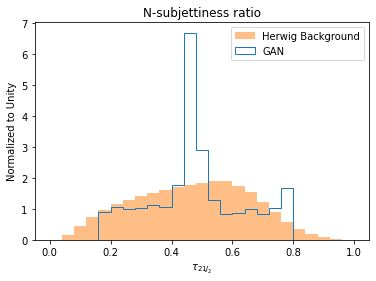

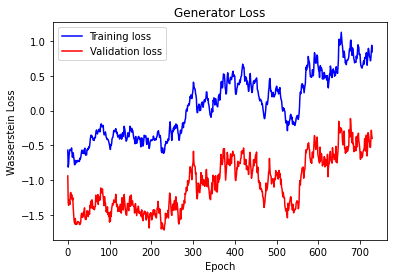

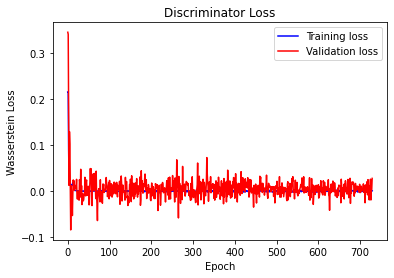

 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [3:53:06<1:47:31, 24.72s/it]


Epoch 740:


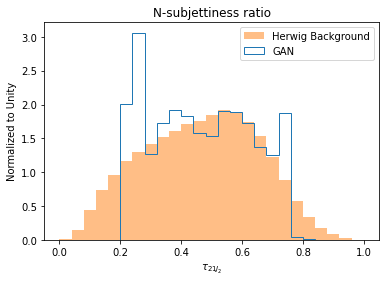

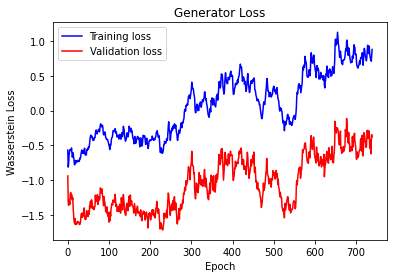

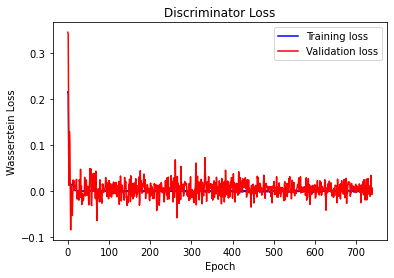

 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [3:57:20<1:45:41, 25.27s/it]


Epoch 750:


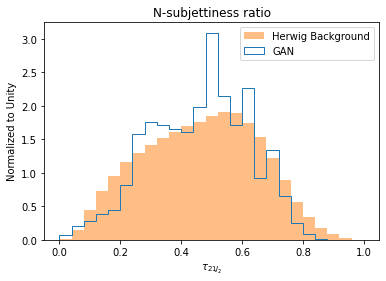

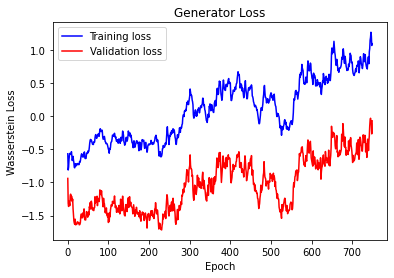

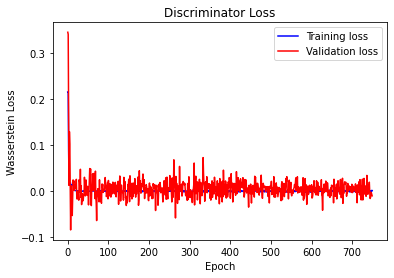

 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [4:01:23<1:35:58, 23.89s/it]


Epoch 760:


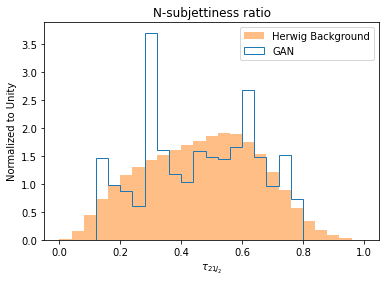

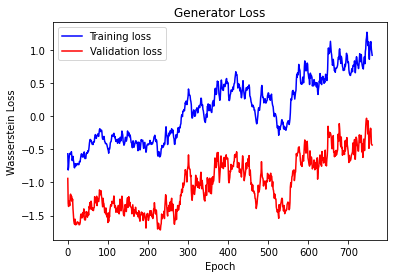

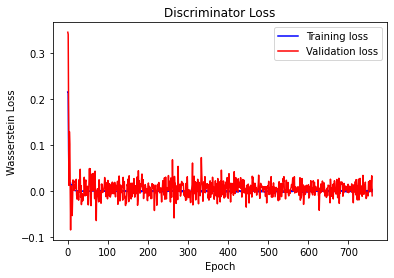

 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [4:05:02<1:19:22, 20.62s/it]


Epoch 770:


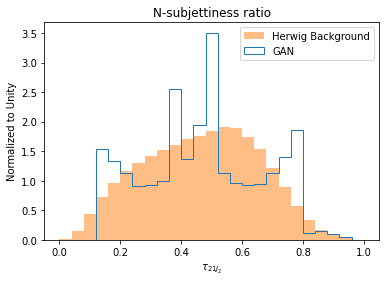

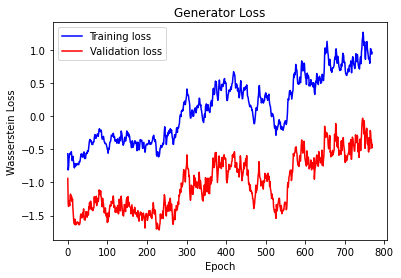

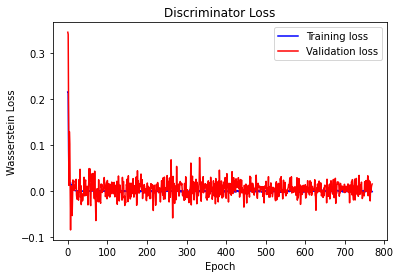

 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [4:08:42<1:18:04, 21.20s/it]


Epoch 780:


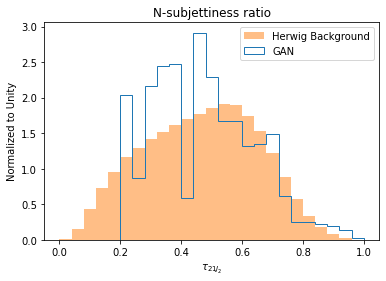

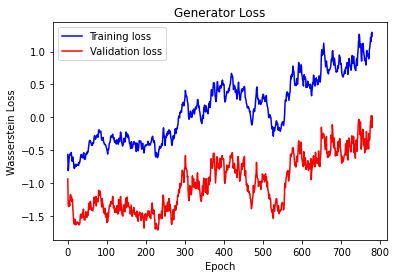

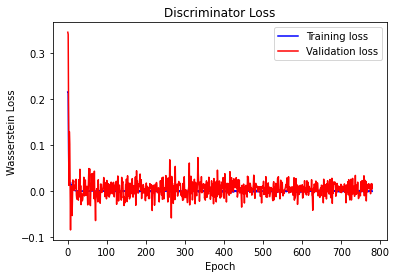

 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [4:12:22<1:18:13, 22.25s/it]


Epoch 790:


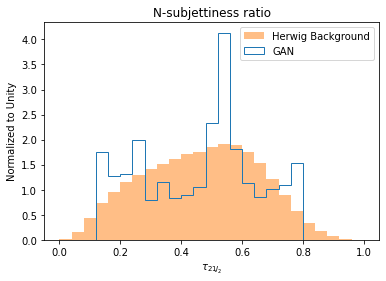

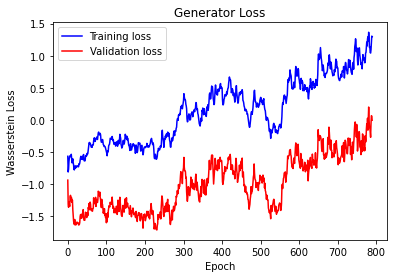

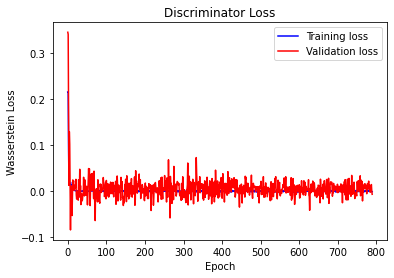

 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [4:16:04<1:14:34, 22.26s/it]


Epoch 800:


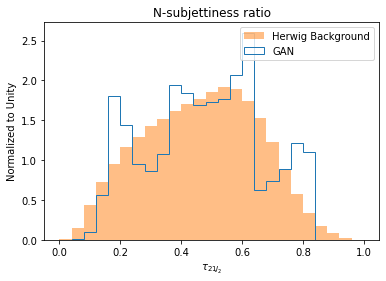

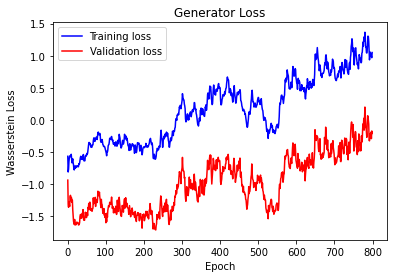

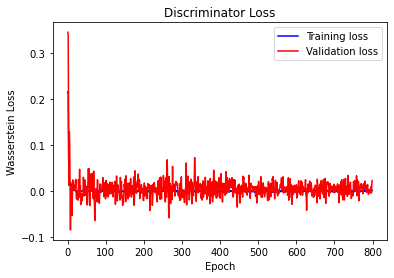

 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [4:19:46<1:11:01, 22.31s/it]


Epoch 810:


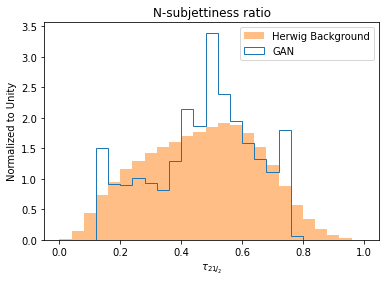

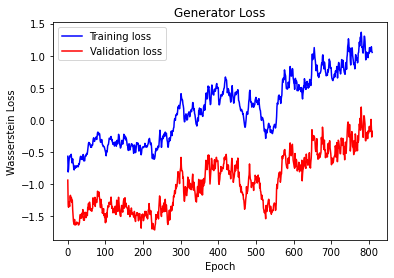

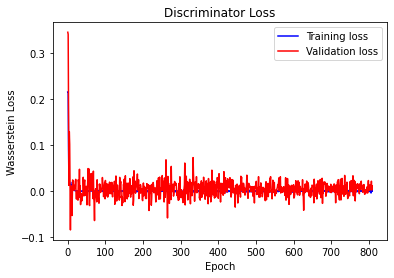

 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [4:23:27<1:06:36, 22.08s/it]


Epoch 820:


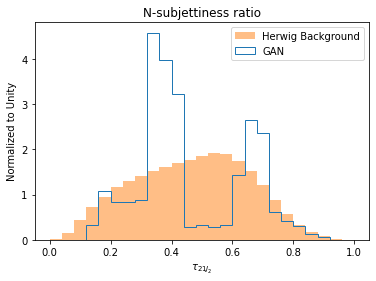

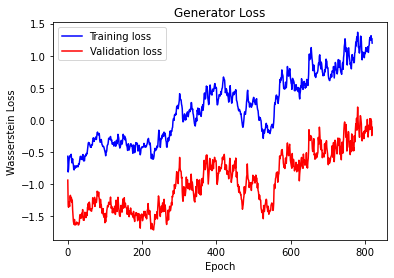

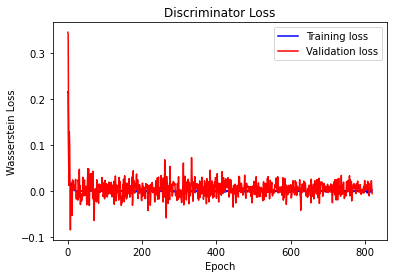

 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [4:27:10<1:04:04, 22.48s/it]


Epoch 830:


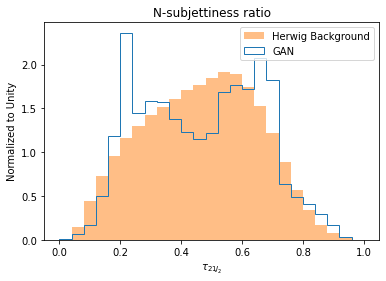

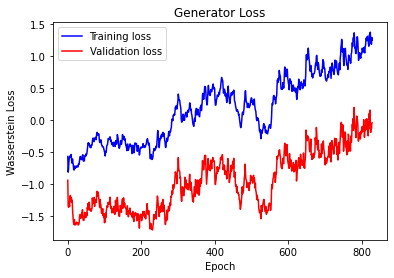

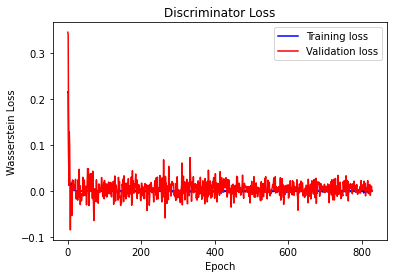

 84%|████████████████████████████████████████████████████████████████▌            | 839/1000 [4:30:53<59:42, 22.25s/it]


Epoch 840:


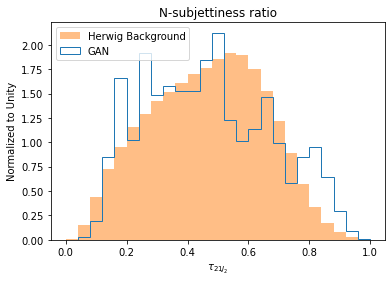

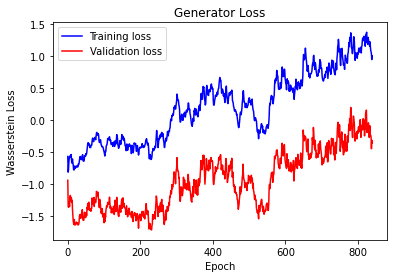

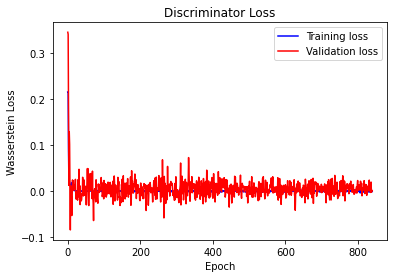

 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [4:34:38<56:36, 22.49s/it]


Epoch 850:


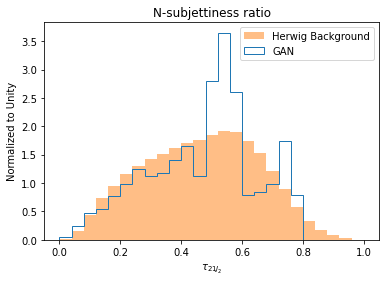

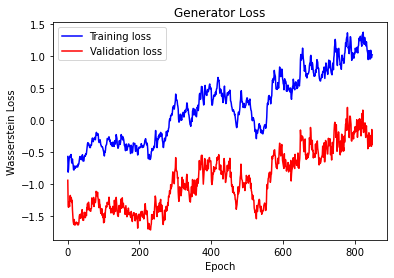

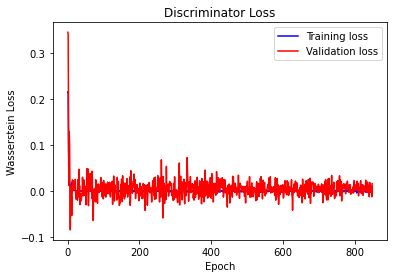

 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [4:38:20<51:41, 22.00s/it]


Epoch 860:


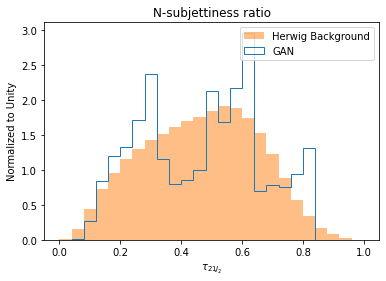

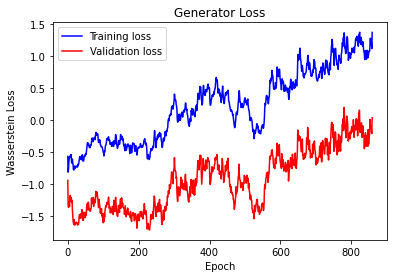

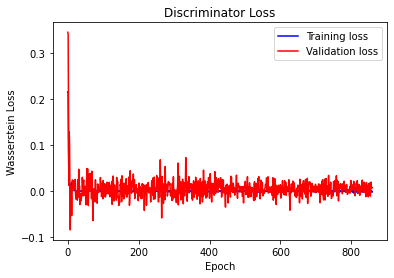

 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [4:42:05<48:50, 22.37s/it]


Epoch 870:


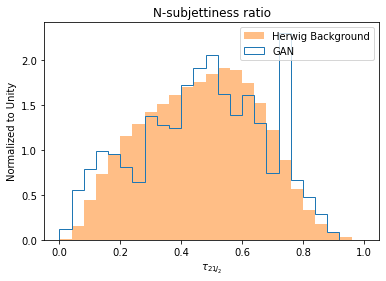

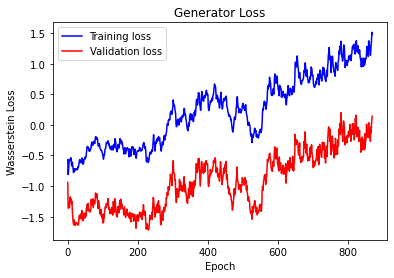

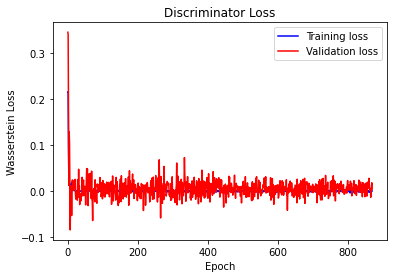

 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [4:45:32<40:35, 20.13s/it]


Epoch 880:


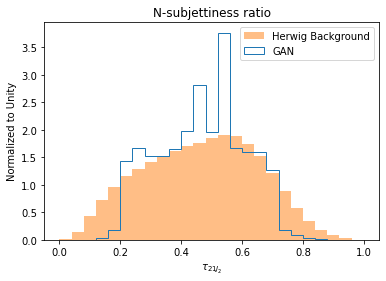

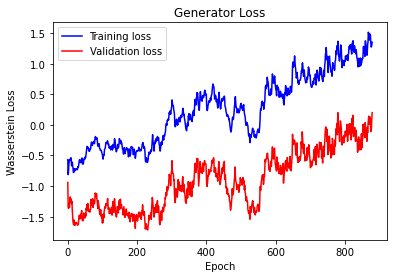

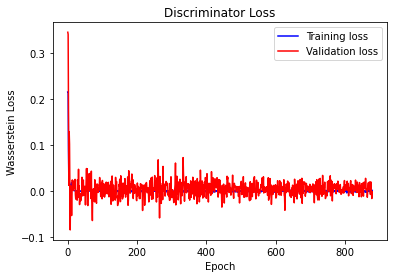

 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [4:48:50<38:23, 20.76s/it]


Epoch 890:


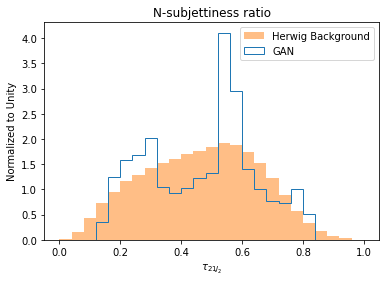

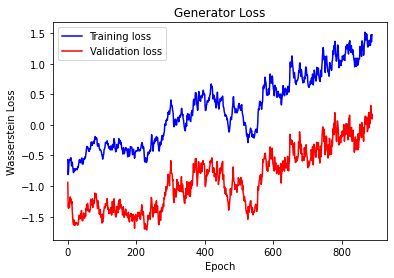

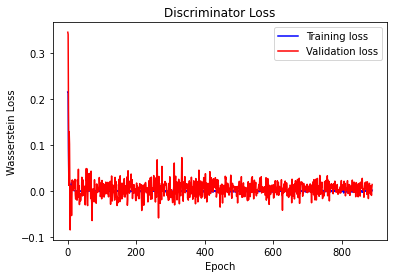

 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [4:52:49<40:06, 23.82s/it]


Epoch 900:


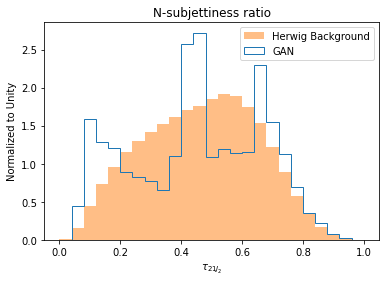

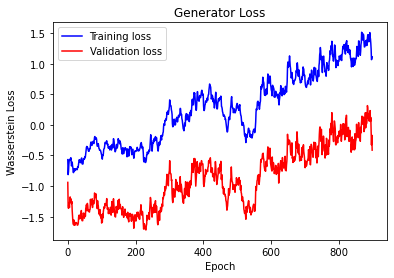

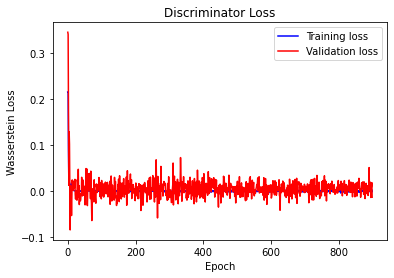

 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [4:56:48<36:20, 23.96s/it]


Epoch 910:


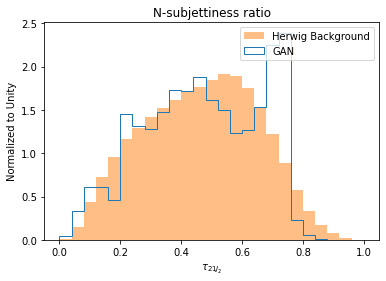

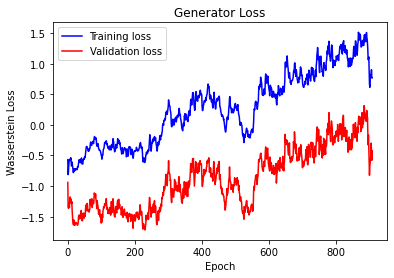

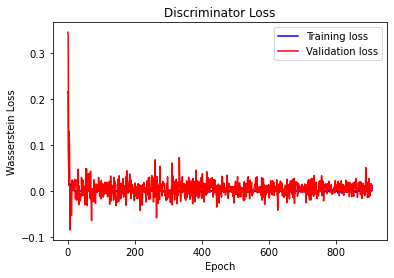

 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [5:00:50<32:34, 24.13s/it]


Epoch 920:


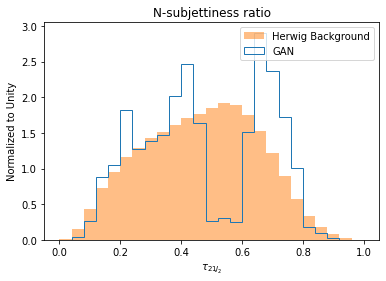

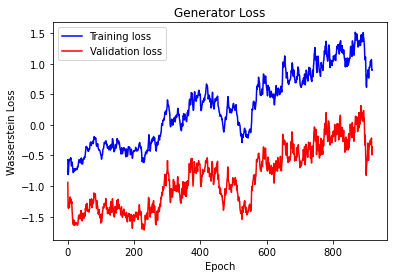

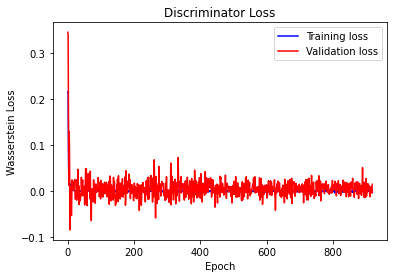

 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [5:05:00<30:03, 25.39s/it]


Epoch 930:


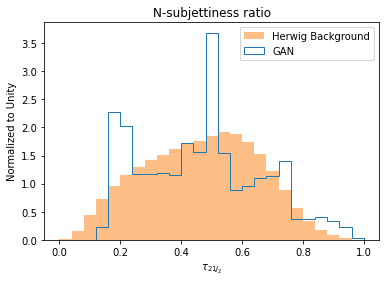

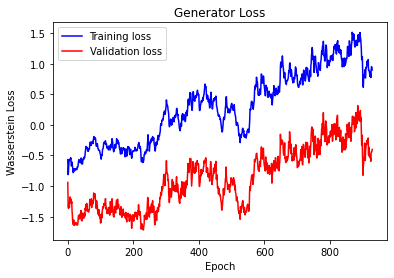

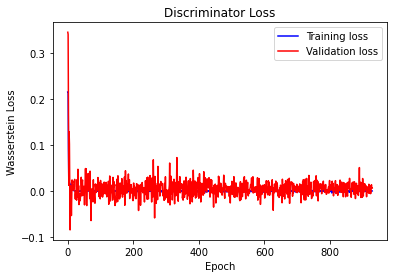

 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [5:09:06<24:21, 23.96s/it]


Epoch 940:


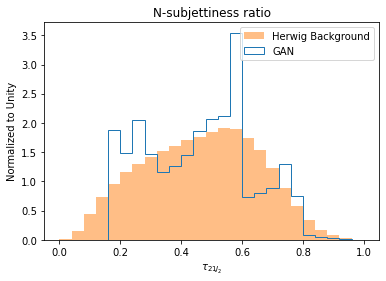

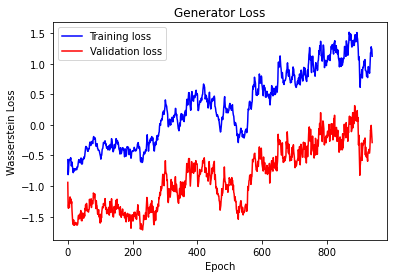

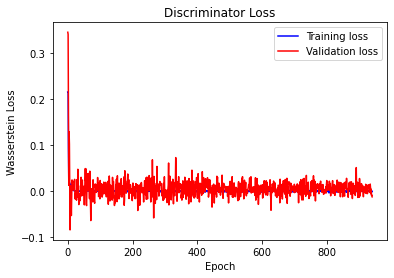

 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [5:11:37<12:30, 14.71s/it]


Epoch 950:


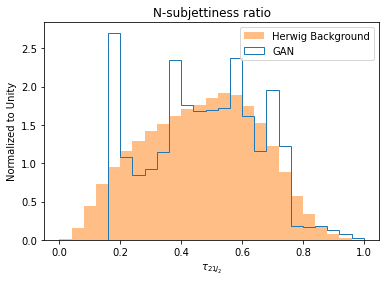

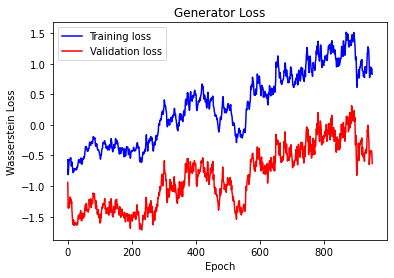

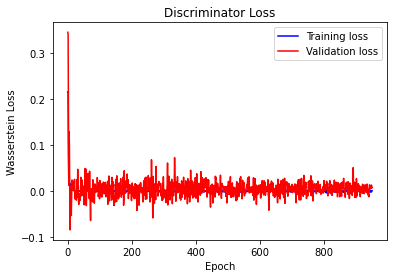

 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [5:13:59<09:43, 14.23s/it]


Epoch 960:


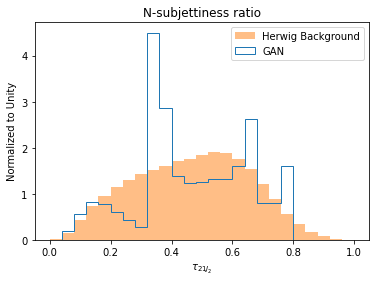

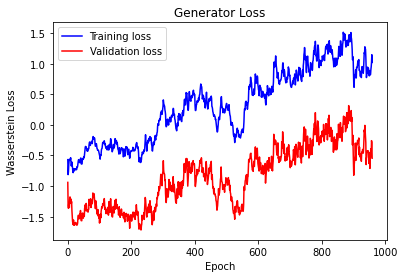

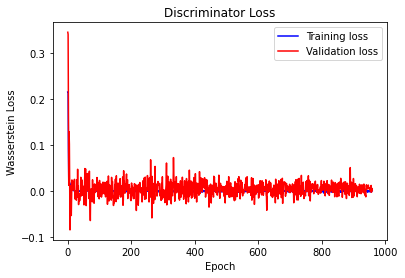

 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [5:16:21<07:19, 14.19s/it]


Epoch 970:


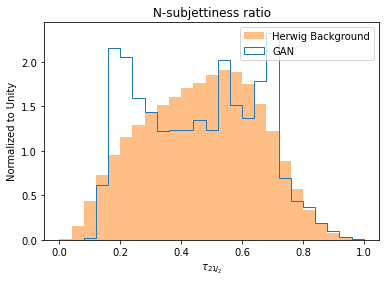

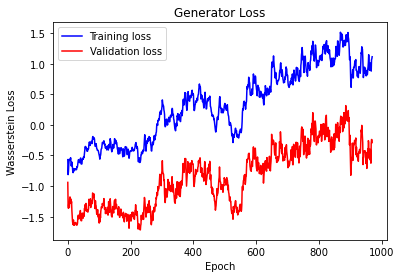

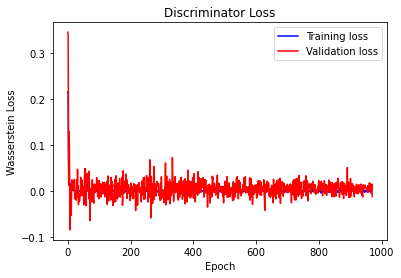

 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [5:18:46<05:09, 14.73s/it]


Epoch 980:


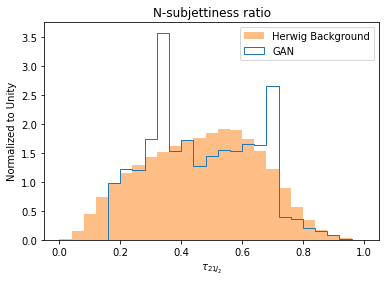

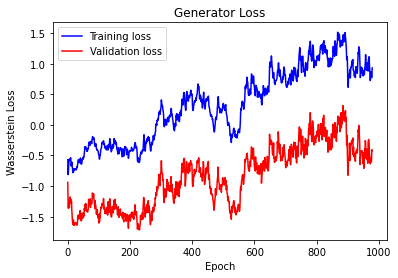

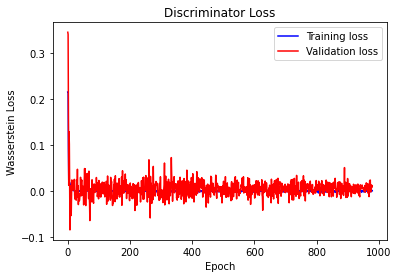

 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [5:21:09<02:36, 14.18s/it]


Epoch 990:


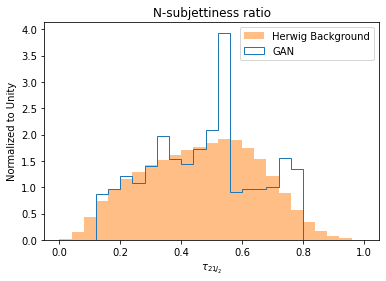

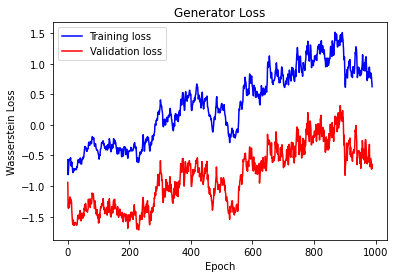

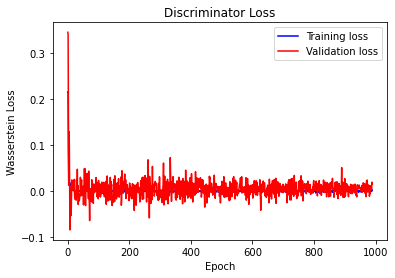

100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [5:23:31<00:14, 14.18s/it]


Epoch 1000:


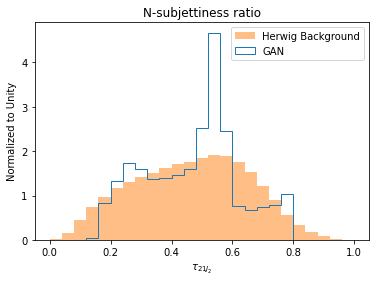

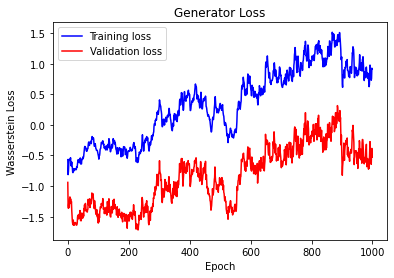

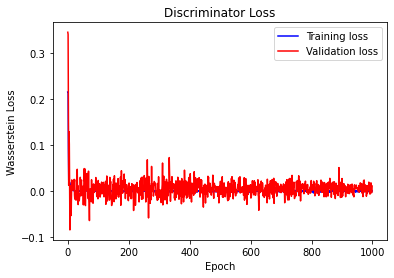

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [5:23:46<00:00, 19.43s/it]


In [29]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)

## Results
???